# Group Members
Chiara Ballanti, 1844613, ballanti.1844613@studenti.uniroma1.it \\
Sophia Balestrucci, 1713638, balestrucci.1713638@studenti.uniroma1.it \\
Paolo Pio Bevilacqua, 2002288, bevilacqua.2002288@studenti.uniroma1.it \\
Ilaria Gagliardi, 1796812, gagliardi.1796812@studenti.uniroma1.it

## Table of contents:
* Initial Setup
* Data Loading and Preprocessing
    * Data Variables
* Model Instantiation
* Optimizer and Scheduler
* Train and Evaluation Loop
    * Save the model and plot the losses (**1 Point**)
* Test Loop  
* Human Pose Visualization (**2 Points**)
* Report and Parameter Fine-Tuning Analysis  (**4 Points**)
* Calculating MPJPE for a Specific Frame  (**2 Points**)
* Iterative Mechanism (**3 Points**)
* YOUR custom model (**3 Points**)
    * Performance BONUS (**Up to 2 Points**)



## Initial Setup
Run the following two cellls to sync with Google Drive only if you run from Google Colab.

*Note: we recommend using Google Colab for this specific homework, since the training phase will require a GPU*

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AML_practice

/content/drive/MyDrive/AML_practice


Welcome to this guide on training, testing, and fine-tuning a deep learning model. Deep learning is at the forefront of artificial intelligence, with applications spanning image recognition, natural language processing, and more.

Throughout this assignment, you'll:

1. **Prepare Data:** Preprocess and load the data.

2. **Use Neural Networks:** Instantiate a neural network architecture.

3. **Train Models:** Utilize optimization, loss functions, and backpropagation.

4. **Evaluate Performance:** Assess model performance, prevent overfitting, and underfitting.

5. **Fine-Tune Models:** Explore hyperparameter tuning.

In [ ]:
from utils import h36motion3d as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.autograd
import torch
import numpy as np
from utils.loss_funcs import *
from utils.data_utils import define_actions
from utils.h36_3d_viz import visualize
import time

import torch.nn.functional as F

from os import makedirs
from os.path import exists

In [ ]:
# Use GPU if available, otherwise stick with cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device,  '- Type:', torch.cuda.get_device_name(0))

Using device: cuda - Type: Tesla T4


## Data Loading and Preprocessing

For this homework, you will use [Human3.6M](https://vision.imar.ro/human3.6m/pami-h36m.pdf), which is a large-scale dataset of 3.6 million accurate 3D human poses acquired by recording the performance of five female and six male subjects under four different viewpoints. The dataset includes:
- Synchronized image.
- Human motion capture.
- Time of flight (depth) data.
- Accurate 3D body scans of all the subject actors involved.

The dataset aims to provide diverse motions and poses encountered in typical human activities, with additional data to train realistic human sensing systems.

![picture](https://drive.google.com/uc?export=view&id=1nyD1_F3r1ctexKFGDmhy2Q9SX_2Z_bpS)

For this assignment, we will leverage the rich **motion data** (See in the figure above) provided by H3.6M to perform a task known as *motion prediction*. Motion prediction involves using historical motion data to forecast future movements. This task is fundamental in human-robot interaction, animation, and sports analytics applications.

### Data Variables

Each created sequence has the shape (35, 17, 3), where:
- Number of observed sequences and number of sequences to predict: $N_{obs}+N_{pred} = 10 + 25 = 35$;
- Number of body joints to consider: $J=22$;
- Spatial coordinates: $(x,y,z) = 3$.


The original data provides high-resolution progressive scan videos at 50 Hz. However, the dataset has been downsampled to 25 Hz for research purposes. This means that 25 frames of motion data are provided per second.

*Note: the figure above shows 18 joints, however the dataset contains 32. For this specific case we will consider 22 joints, ignoring some of the finer ones (e.g. foot tip, hand tip, etc)*


In [ ]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n=10 # number of frames to train on (default=10)
output_n=25 # number of frames to predict on
input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22


#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path= './checkpoints/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2

Load Dataset

*Note: It will take you ~ 5 minutes*

In [ ]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

Loading Train Dataset...


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


Loading Validation Dataset...


Following we create a torch dataloader that create the batches for each epoch.

In [ ]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

>>> Training dataset length: 180077
>>> Validation dataset length: 28110


## Model instantiation


Each sequence comprises an **observed** part to train the Encoder and a part that attempts to predict the **future** sequence, the Decoder.

Generally, the standard setup plans to use the first 10 sequences of poses ($N_{obs}=10$) for the observation and the following 25 ($N_{pred} = 25$) for the prediction.


We create an instance of a custom Spatio-Temporal transformer with the chosen configuration.

(*Note: explore the model in ./models/sttr/sttformer.py*)

Then we allocate it to the GPU for forward and backward accelerated computation.

In [ ]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Using device: cuda
total number of parameters of the network is: 26859


## Optimizer and Scheduler

As we embark on training deep learning models for motion prediction using the H3.6M dataset, it's essential to recognize several key parameters and components that significantly impact the training phase:

- **Learning Rate:** This parameter determines the convergence speed during optimization.

- **Batch Size:** It influences model generalization and training efficiency.

- **Number of Epochs:** The number of training iterations affects model learning.

- **Loss Function:** The choice of loss function directly affects learning and final performance.

- **Optimizer:** The optimization algorithm used (e.g., Adam, SGD) impacts gradient descent during training.

- **Milestones and Gamma:** These parameters control learning rate schedules, allowing for adaptive adjustments during training.

- **Weight Decay:** It regulates the impact of model parameters during optimization.

- **Scheduler:** Scheduler strategies (e.g., StepLR, ReduceLROnPlateau) manage learning rate adaptation during training.

In [ ]:
# Arguments to setup the optimizer
lr=1e-01 # learning rate
use_scheduler=True # use MultiStepLR scheduler
milestones=[10, 30]   # the epochs after which the learning rate is adjusted by gamma
gamma=0.1 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay=1e-05 # weight decay (L2 penalty)
optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [ ]:
clip_grad=None # select max norm to clip gradients
# Argument for training
n_epochs=41
log_step = 200

## Train and Evaluation Loop

The **loss** and **metric** used during training and evaluation respectively, compare the predicted joint positions to ground truth joint positions for all frames, which is typically referred to as the **Average Mean Per
Joint Position Error (A-MPJPE)** can be seen as an $L_2$. This loss quantifies the dissimilarity between the predicted and ground truth joint positions by measuring the squared Euclidean distance between corresponding joint positions.

\begin{align*}
A-MPJPE &= \frac{1}{N_{pred}} \sum_{i=1}^{N_{pred}} \left(\frac{1}{J} \sum_{j=1}^{J} \left\| P_{\text{predicted}_{t,j}} - P_{\text{gt}_{t,j}} \right\|^2\right)
\end{align*}

$$where:$$

\begin{align*}
P_{\text{predicted}} &: \text{Set of predicted joint positions estimated by the model.} \\
P_{\text{gt}} &: \text{Corresponding set of ground truth joint positions.} \\
\end{align*}

*Note: If you restart the training for any reason, remember to instantiate the model and the optimizer again. This will avoid continuing the training with the initialized weights of the previous one*


### Save the model and plot the losses (1 Point)

**Objective:** In this exercise, you will practice implementing a code snippet to save your deep learning model's checkpoints and visualize the training and validation loss on the same plot every 5 epochs during model training.

Your task is to implement the following:

- Set up a mechanism to save the model's checkpoints (weights and architecture) during training. These checkpoints should be saved periodically, say, **every 5 epochs**.

- Create a plot displaying the training and validation losses on the same graph. The x-axis should represent the number of epochs, and the y-axis should represent the loss values. The training and validation losses should be plotted as separate lines on the same graph.

- Ensure that the code saves the model's checkpoints in a specified directory, including the model's architecture and weights, and that the loss plot is displayed.

Analyze the loss plot to gain insights into how your model is learning over time and whether there are any signs of overfitting or underfitting.

*Note: see the Pytorch Documentation on how to save your model's checkpoints.*


In [ ]:
def train(data_loader,vald_loader, path_to_save_model=None):
  train_loss = []
  val_loss = []
  val_loss_best = 1000

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs-1):
      running_loss=0
      n=0
      model.train()
      for cnt,batch in enumerate(data_loader):
          batch=batch.float().to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

          optimizer.zero_grad()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)


          loss=mpjpe_error(sequences_predict,sequences_gt)


          if cnt % log_step == 0:
            print('[Epoch: %d, Iteration: %5d]  training loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(),clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim

      train_loss.append(running_loss.detach().cpu()/n)
      model.eval()
      with torch.no_grad():
          running_loss=0
          n=0
          for cnt,batch in enumerate(vald_loader):
              batch=batch.float().to(device)
              batch_dim=batch.shape[0]
              n+=batch_dim


              sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
              sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

              sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
              loss=mpjpe_error(sequences_predict,sequences_gt)

              if cnt % log_step == 0:
                        print('[Epoch: %d, Iteration: %5d]  validation loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))
              running_loss+=loss*batch_dim
          val_loss.append(running_loss.detach().cpu()/n)
          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n

      if use_scheduler:
        scheduler.step()

      # save and plot model every 5 epochs
      '''
      Insert your code below. Use the argument path_to_save_model to save the model to the path specified.
      '''
      if save_and_plot and (epoch + 1) % 5 == 0:

        if path_to_save_model is not None:
          checkpoint_path = path_to_save_model + f'h36m_3d_25frames_ckpt_epoch_{epoch + 1}.pth'
          torch.save(model.state_dict(), checkpoint_path)

        # Create a plot for training and validation losses
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 6))
        plt.plot(range(epoch + 1), train_loss, label='Training Loss', marker='o')
        plt.plot(range(epoch + 1), val_loss, label='Validation Loss', marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)

        # Save the loss plot to a file if needed
        if path_to_save_model is not None:
            loss_plot_path = path_to_save_model + f'loss_plot_epoch_{epoch + 1}.png'
            plt.savefig(loss_plot_path)

        plt.show()

[Epoch: 1, Iteration:     1]  training loss: 557.110
[Epoch: 1, Iteration:   201]  training loss: 131.025
[Epoch: 1, Iteration:   401]  training loss: 112.306
[Epoch: 1, Iteration:   601]  training loss: 112.207
[Epoch: 1, Iteration:     1]  validation loss: 106.389
[Epoch: 2, Iteration:     1]  training loss: 109.696
[Epoch: 2, Iteration:   201]  training loss: 106.374
[Epoch: 2, Iteration:   401]  training loss: 102.856
[Epoch: 2, Iteration:   601]  training loss: 99.331
[Epoch: 2, Iteration:     1]  validation loss: 100.675
[Epoch: 3, Iteration:     1]  training loss: 98.116
[Epoch: 3, Iteration:   201]  training loss: 102.311
[Epoch: 3, Iteration:   401]  training loss: 100.772
[Epoch: 3, Iteration:   601]  training loss: 96.109
[Epoch: 3, Iteration:     1]  validation loss: 92.432
[Epoch: 4, Iteration:     1]  training loss: 95.607
[Epoch: 4, Iteration:   201]  training loss: 94.105
[Epoch: 4, Iteration:   401]  training loss: 97.394
[Epoch: 4, Iteration:   601]  training loss: 93

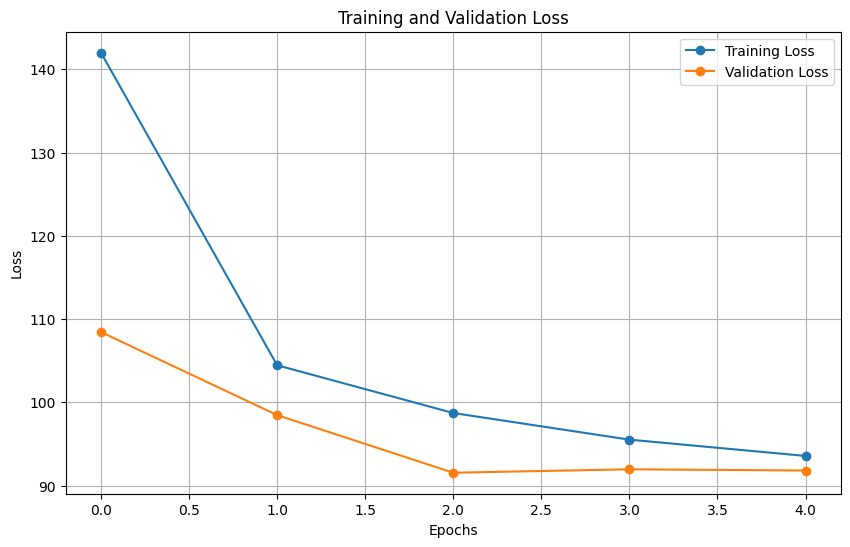

[Epoch: 6, Iteration:     1]  training loss: 93.807
[Epoch: 6, Iteration:   201]  training loss: 86.476
[Epoch: 6, Iteration:   401]  training loss: 87.819
[Epoch: 6, Iteration:   601]  training loss: 87.447
[Epoch: 6, Iteration:     1]  validation loss: 87.013
[Epoch: 7, Iteration:     1]  training loss: 88.334
[Epoch: 7, Iteration:   201]  training loss: 89.479
[Epoch: 7, Iteration:   401]  training loss: 97.097
[Epoch: 7, Iteration:   601]  training loss: 86.381
[Epoch: 7, Iteration:     1]  validation loss: 85.640
[Epoch: 8, Iteration:     1]  training loss: 90.612
[Epoch: 8, Iteration:   201]  training loss: 96.223
[Epoch: 8, Iteration:   401]  training loss: 90.596
[Epoch: 8, Iteration:   601]  training loss: 90.287
[Epoch: 8, Iteration:     1]  validation loss: 85.680
[Epoch: 9, Iteration:     1]  training loss: 89.180
[Epoch: 9, Iteration:   201]  training loss: 89.104
[Epoch: 9, Iteration:   401]  training loss: 92.185
[Epoch: 9, Iteration:   601]  training loss: 88.370
[Epoch

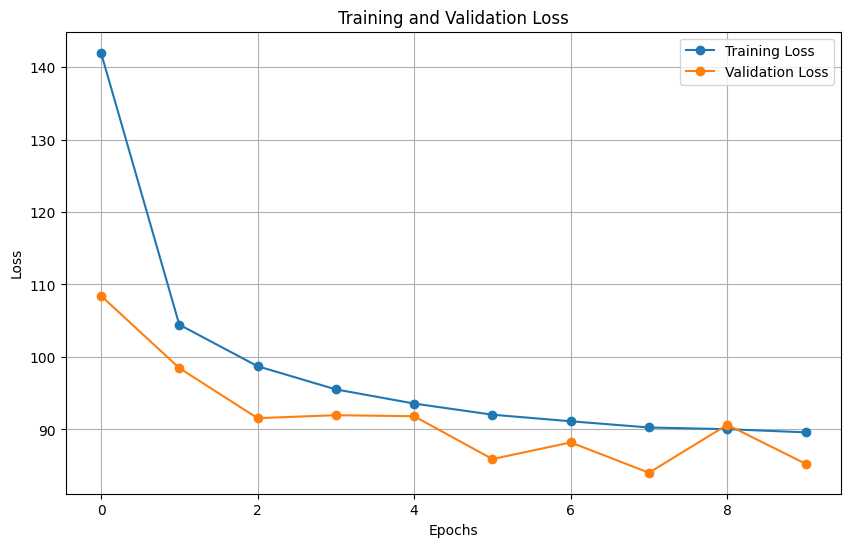

[Epoch: 11, Iteration:     1]  training loss: 88.548
[Epoch: 11, Iteration:   201]  training loss: 82.885
[Epoch: 11, Iteration:   401]  training loss: 86.018
[Epoch: 11, Iteration:   601]  training loss: 84.424
[Epoch: 11, Iteration:     1]  validation loss: 82.412
[Epoch: 12, Iteration:     1]  training loss: 84.995
[Epoch: 12, Iteration:   201]  training loss: 84.348
[Epoch: 12, Iteration:   401]  training loss: 85.954
[Epoch: 12, Iteration:   601]  training loss: 86.075
[Epoch: 12, Iteration:     1]  validation loss: 80.622
[Epoch: 13, Iteration:     1]  training loss: 83.493
[Epoch: 13, Iteration:   201]  training loss: 84.534
[Epoch: 13, Iteration:   401]  training loss: 87.368
[Epoch: 13, Iteration:   601]  training loss: 90.460
[Epoch: 13, Iteration:     1]  validation loss: 78.107
[Epoch: 14, Iteration:     1]  training loss: 85.813
[Epoch: 14, Iteration:   201]  training loss: 87.537
[Epoch: 14, Iteration:   401]  training loss: 82.686
[Epoch: 14, Iteration:   601]  training 

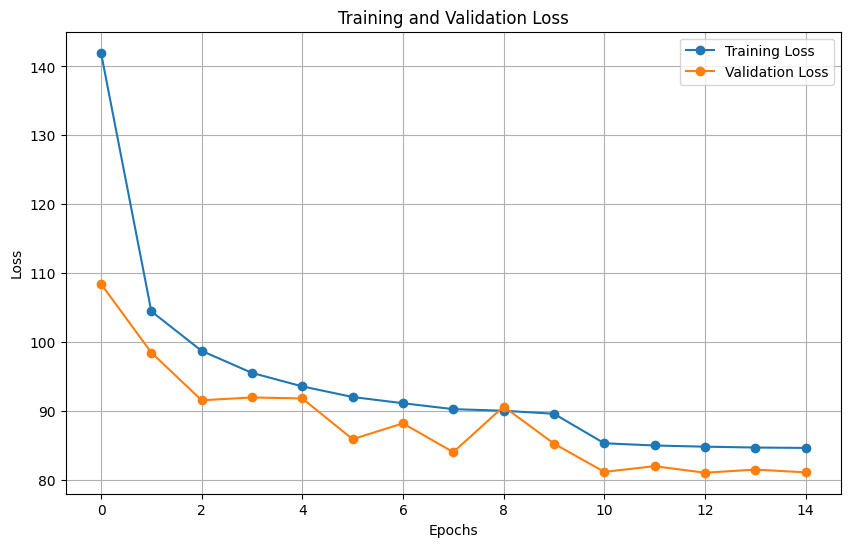

[Epoch: 16, Iteration:     1]  training loss: 84.236
[Epoch: 16, Iteration:   201]  training loss: 83.850
[Epoch: 16, Iteration:   401]  training loss: 81.269
[Epoch: 16, Iteration:   601]  training loss: 84.744
[Epoch: 16, Iteration:     1]  validation loss: 77.549
[Epoch: 17, Iteration:     1]  training loss: 89.851
[Epoch: 17, Iteration:   201]  training loss: 80.832
[Epoch: 17, Iteration:   401]  training loss: 79.816
[Epoch: 17, Iteration:   601]  training loss: 87.305
[Epoch: 17, Iteration:     1]  validation loss: 75.119
[Epoch: 18, Iteration:     1]  training loss: 80.951
[Epoch: 18, Iteration:   201]  training loss: 87.186
[Epoch: 18, Iteration:   401]  training loss: 86.265
[Epoch: 18, Iteration:   601]  training loss: 85.619
[Epoch: 18, Iteration:     1]  validation loss: 82.243
[Epoch: 19, Iteration:     1]  training loss: 88.676
[Epoch: 19, Iteration:   201]  training loss: 85.479
[Epoch: 19, Iteration:   401]  training loss: 84.483
[Epoch: 19, Iteration:   601]  training 

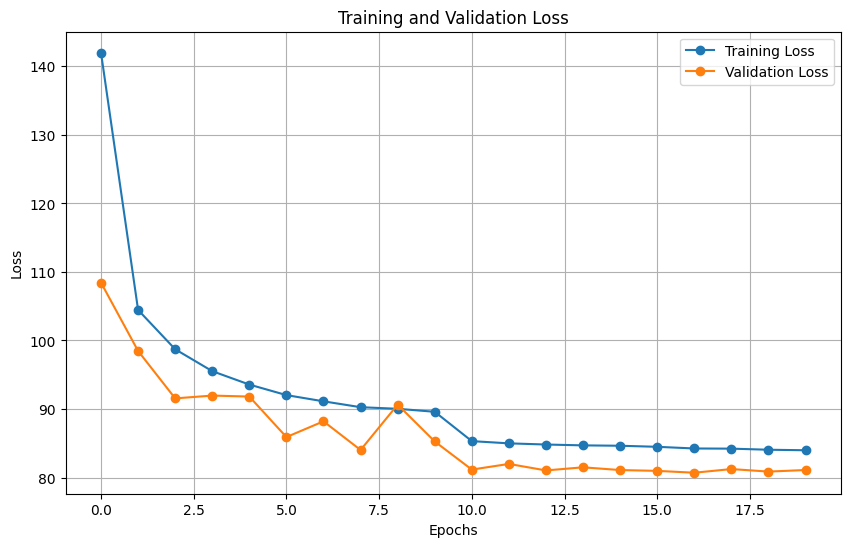

[Epoch: 21, Iteration:     1]  training loss: 84.134
[Epoch: 21, Iteration:   201]  training loss: 83.998
[Epoch: 21, Iteration:   401]  training loss: 79.940
[Epoch: 21, Iteration:   601]  training loss: 80.314
[Epoch: 21, Iteration:     1]  validation loss: 80.845
[Epoch: 22, Iteration:     1]  training loss: 80.860
[Epoch: 22, Iteration:   201]  training loss: 81.666
[Epoch: 22, Iteration:   401]  training loss: 81.701
[Epoch: 22, Iteration:   601]  training loss: 86.314
[Epoch: 22, Iteration:     1]  validation loss: 80.561
[Epoch: 23, Iteration:     1]  training loss: 86.180
[Epoch: 23, Iteration:   201]  training loss: 83.489
[Epoch: 23, Iteration:   401]  training loss: 83.166
[Epoch: 23, Iteration:   601]  training loss: 85.431
[Epoch: 23, Iteration:     1]  validation loss: 80.983
[Epoch: 24, Iteration:     1]  training loss: 79.248
[Epoch: 24, Iteration:   201]  training loss: 86.635
[Epoch: 24, Iteration:   401]  training loss: 83.701
[Epoch: 24, Iteration:   601]  training 

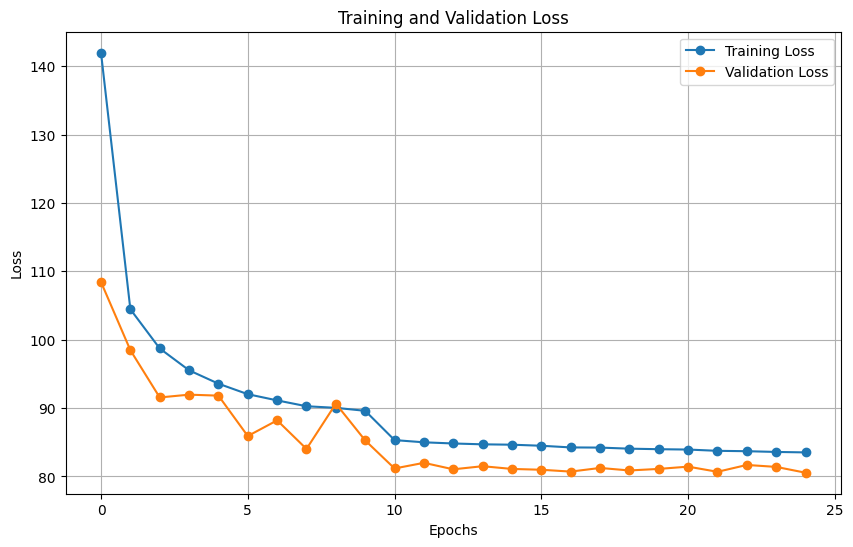

[Epoch: 26, Iteration:     1]  training loss: 82.719
[Epoch: 26, Iteration:   201]  training loss: 80.462
[Epoch: 26, Iteration:   401]  training loss: 81.486
[Epoch: 26, Iteration:   601]  training loss: 85.416
[Epoch: 26, Iteration:     1]  validation loss: 80.908
[Epoch: 27, Iteration:     1]  training loss: 85.493
[Epoch: 27, Iteration:   201]  training loss: 81.606
[Epoch: 27, Iteration:   401]  training loss: 81.099
[Epoch: 27, Iteration:   601]  training loss: 85.813
[Epoch: 27, Iteration:     1]  validation loss: 81.329
[Epoch: 28, Iteration:     1]  training loss: 86.055
[Epoch: 28, Iteration:   201]  training loss: 86.334
[Epoch: 28, Iteration:   401]  training loss: 87.182
[Epoch: 28, Iteration:   601]  training loss: 83.614
[Epoch: 28, Iteration:     1]  validation loss: 82.142
[Epoch: 29, Iteration:     1]  training loss: 79.367
[Epoch: 29, Iteration:   201]  training loss: 86.285
[Epoch: 29, Iteration:   401]  training loss: 83.372
[Epoch: 29, Iteration:   601]  training 

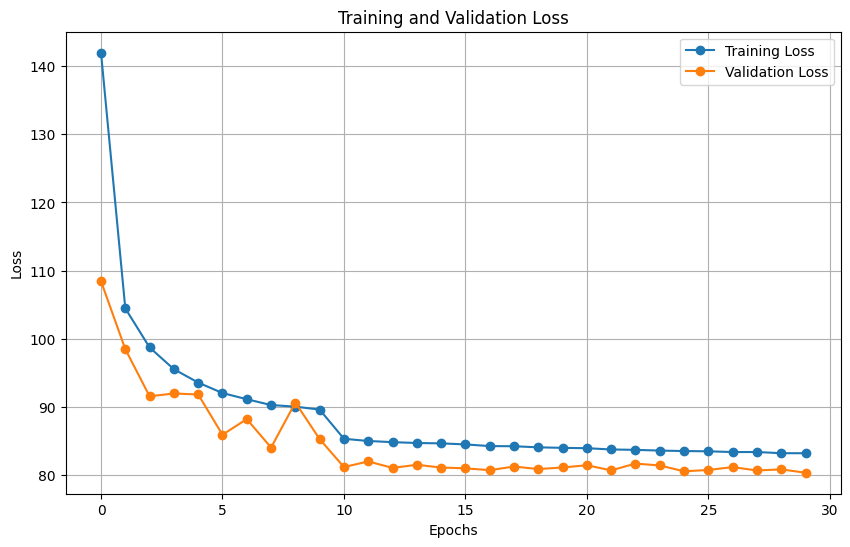

[Epoch: 31, Iteration:     1]  training loss: 84.894
[Epoch: 31, Iteration:   201]  training loss: 85.092
[Epoch: 31, Iteration:   401]  training loss: 84.165
[Epoch: 31, Iteration:   601]  training loss: 88.001
[Epoch: 31, Iteration:     1]  validation loss: 79.436
[Epoch: 32, Iteration:     1]  training loss: 79.399
[Epoch: 32, Iteration:   201]  training loss: 87.005
[Epoch: 32, Iteration:   401]  training loss: 80.064
[Epoch: 32, Iteration:   601]  training loss: 81.392
[Epoch: 32, Iteration:     1]  validation loss: 82.585
[Epoch: 33, Iteration:     1]  training loss: 84.610
[Epoch: 33, Iteration:   201]  training loss: 87.631
[Epoch: 33, Iteration:   401]  training loss: 83.445
[Epoch: 33, Iteration:   601]  training loss: 83.674
[Epoch: 33, Iteration:     1]  validation loss: 77.807
[Epoch: 34, Iteration:     1]  training loss: 81.244
[Epoch: 34, Iteration:   201]  training loss: 86.987
[Epoch: 34, Iteration:   401]  training loss: 84.441
[Epoch: 34, Iteration:   601]  training 

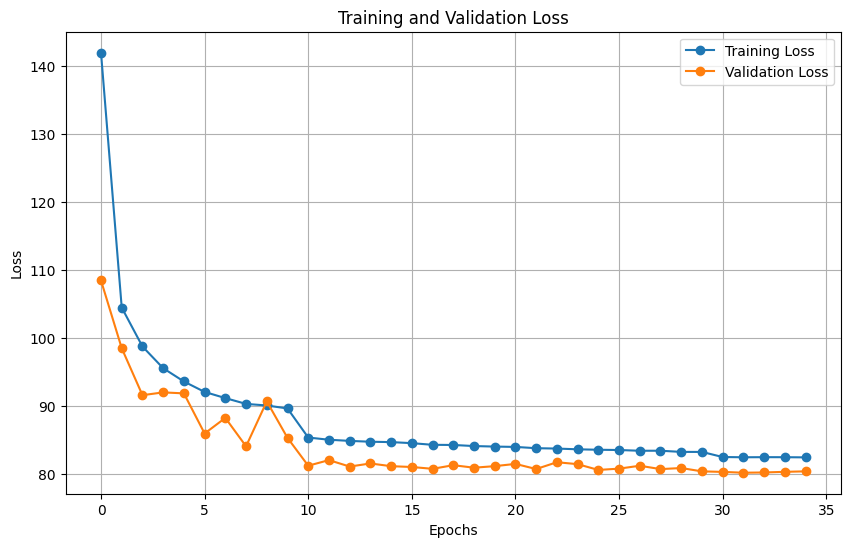

[Epoch: 36, Iteration:     1]  training loss: 83.313
[Epoch: 36, Iteration:   201]  training loss: 81.976
[Epoch: 36, Iteration:   401]  training loss: 81.688
[Epoch: 36, Iteration:   601]  training loss: 83.689
[Epoch: 36, Iteration:     1]  validation loss: 82.300
[Epoch: 37, Iteration:     1]  training loss: 85.368
[Epoch: 37, Iteration:   201]  training loss: 84.425
[Epoch: 37, Iteration:   401]  training loss: 81.935
[Epoch: 37, Iteration:   601]  training loss: 80.201
[Epoch: 37, Iteration:     1]  validation loss: 78.388
[Epoch: 38, Iteration:     1]  training loss: 81.958
[Epoch: 38, Iteration:   201]  training loss: 82.212
[Epoch: 38, Iteration:   401]  training loss: 84.521
[Epoch: 38, Iteration:   601]  training loss: 86.073
[Epoch: 38, Iteration:     1]  validation loss: 79.547
[Epoch: 39, Iteration:     1]  training loss: 86.787
[Epoch: 39, Iteration:   201]  training loss: 82.704
[Epoch: 39, Iteration:   401]  training loss: 83.202
[Epoch: 39, Iteration:   601]  training 

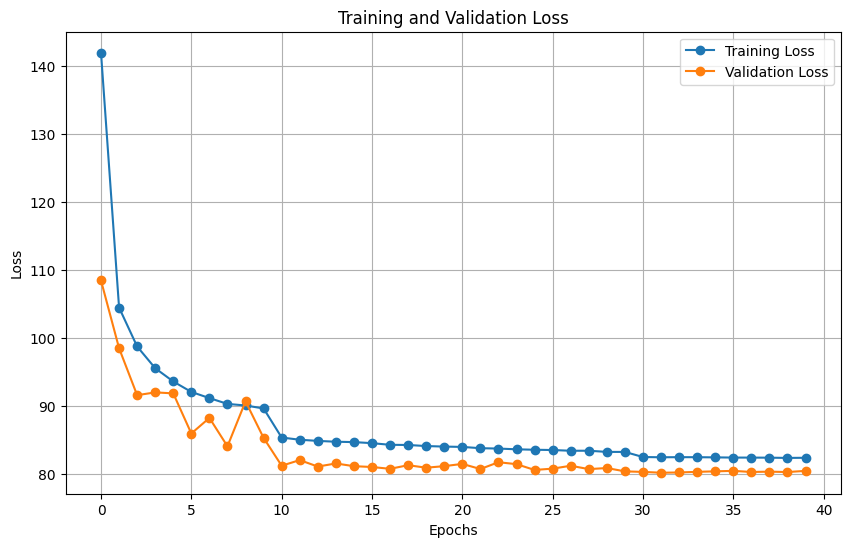

In [ ]:
save_and_plot = True # save the model and plot the loss. Change to True if you want to save the model and plot the loss

# launch training
train(data_loader,vald_loader, path_to_save_model=model_path)

## Test Loop

After training and validation, the test loop is the final phase that evaluates the model's performance on an entirely independent dataset known as the test dataset. This dataset is distinct from the training and validation data, ensuring unbiased assessment. The test loop provides a reliable estimate of how well the model will perform in real-world scenarios, confirming that any improvements observed during training and validation are not due to overfitting or chance. It's a crucial step before deploying the model in practical applications.

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
      # print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)

          totalll += time.time()-running_time
          counter += 1
          sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss=mpjpe_error(all_joints_seq.view(-1,output_n,32,3),sequences_gt.view(-1,output_n,32,3))
          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: '+str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)


*Note: Your results should be better than 95 millimiters on average*

In [ ]:
ckpt_path = './checkpoints/h36m_3d_25frames_ckpt_epoch_30.pth' # Change the epoch according to the validation curve # TODO run
test(ckpt_path)

model loaded


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


walking :  62.2
eating :  62.0
smoking :  62.5
discussion :  88.4
directions :  79.0
greeting :  101.2
phoning :  77.9
posing :  116.1
purchases :  103.1
sitting :  90.5
sittingdown :  113.0
takingphoto :  86.8
waiting :  83.0
walkingdog :  112.1
walkingtogether :  60.0
Average: 86.5
Prediction time:  0.010554736355940501


## Human Pose Visualization  (**2 Points**)

The qualitative results are as important as the quantitative ones. In this section, you will visualize and compare the predicted poses with the ground truth ones.
For simplicity, you will visualize only the first predicted pose and the ground truth.

Ideally, the same plot should show the predicted pose in red and the ground truth one in green.

*Note: you will find which nodes are connected in the file ./models/skeleton_connection.py*

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from utils import h36motion3d as datasets
from utils.loss_funcs import mpjpe_error
from utils.data_utils import define_actions

In [ ]:
def create_pose(ax,plots,vals,pred=True,update=False):

    # [16, 20, 23, 24, 28, 31] IGNORE
    # [13, 19, 22, 13, 27, 30] EQUAL
    # h36m 32 joints(full)
    connect = [
            (1, 2), (2, 3), (3, 4), (4, 5),
            (6, 7), (7, 8), (8, 9), (9, 10),
            (0, 1), (0, 6),
            (6, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22),
            (1, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
            (24, 25), (24, 17),
            (24, 14), (14, 15)
    ]

    LR = [
            False, True, True, True,
            True, True, False, False,
             False, False,
            False, True, True, True, True, True, True,
            False, False, False, False, False, False, False, True,
            False, True, True, True, True,
            True, True
    ]

    # Start and endpoints of our representation
    I   = np.array([touple[0] for touple in connect])
    J   = np.array([touple[1] for touple in connect])

    # Left / right indicator
    LR  = np.array([LR[a] or LR[b] for a,b in connect])
    if pred:
        lcolor = "#f01313"
        rcolor = "#f01313"
    else:
        lcolor = "#2ade2d"
        rcolor = "#2ade2d"

    for i in np.arange( len(I) ):
        x = np.array( [vals[I[i], 0], vals[J[i], 0]] )
        z = np.array( [vals[I[i], 1], vals[J[i], 1]] )
        y = np.array( [vals[I[i], 2], vals[J[i], 2]] )
        if not update:

            if i ==0:
                plots.append(ax.plot(x, y, z, lw=2,linestyle='--' ,c=lcolor if LR[i] else rcolor,label=['Input Frames' if not pred else 'Predicted Frames']))
            else:
                plots.append(ax.plot(x, y, z, lw=2,linestyle='--', c=lcolor if LR[i] else rcolor))

        elif update:
            plots[i][0].set_xdata(x)
            plots[i][0].set_ydata(y)
            plots[i][0].set_3d_properties(z)
            plots[i][0].set_color(lcolor if LR[i] else rcolor)

    return plots


def update(num,data_gt,data_pred,plots_gt,plots_pred,fig,ax):

    gt_vals=data_gt[num]
    pred_vals=data_pred[num]
    plots_gt=create_pose(ax,plots_gt,gt_vals,pred=False,update=True)
    plots_pred=create_pose(ax,plots_pred,pred_vals,pred=True,update=True)

    r = 0.75
    xroot, zroot, yroot = gt_vals[0,0], gt_vals[0,1], gt_vals[0,2]
    ax.set_xlim3d([-r+xroot, r+xroot])
    ax.set_ylim3d([-r+yroot, r+yroot])
    ax.set_zlim3d([-r+zroot, r+zroot])
    #ax.set_title('pose at time frame: '+str(num))
    #ax.set_aspect('equal')

    return plots_gt ,plots_pred

In [ ]:
def visualize_3d_plot(input_n,output_n,visualize_from,path,modello,device,n_viz,skip_rate,actions):

  actions = define_actions(actions)

  print(actions)

  for action in actions:
      print(f" ... doing action = {action}")

      if visualize_from == 'train':
          loader = datasets.Datasets(path, input_n, output_n, skip_rate, split=0, actions=[action])
      elif visualize_from == 'validation':
          loader = datasets.Datasets(path, input_n, output_n, skip_rate, split=1, actions=[action])
      elif visualize_from == 'test':
          loader = datasets.Datasets(path, input_n, output_n, skip_rate, split=2, actions=[action])

      dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                          26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                          46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                          75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
      # joints at same loc
      joints_to_consider = 22
      joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
      index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
      joint_equal = np.array([13, 19, 22, 13, 27, 30])
      index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))

      loader = DataLoader(loader, batch_size=1, shuffle=True, num_workers=0)

      for cnt, batch in enumerate(loader):

          batch = batch.to(device)

          all_joints_seq = batch.clone()[:, input_n:input_n + output_n, :]


          sequences_train = batch[:, 0:input_n, dim_used].view(-1, input_n, len(dim_used) // 3, 3).permute(0, 3, 1, 2)
          sequences_gt = batch[:, input_n:input_n + output_n, :]

          sequences_predict = modello(sequences_train).view(-1, output_n, joints_to_consider, 3)
          sequences_predict = sequences_predict.contiguous().view(-1, output_n, len(dim_used))
          all_joints_seq[:, :, dim_used] = sequences_predict

          all_joints_seq[:, :, index_to_ignore] = all_joints_seq[:, :, index_to_equal]

          all_joints_seq = all_joints_seq.view(-1, output_n, 32, 3)

          sequences_gt = sequences_gt.view(-1, output_n, 32, 3)

          loss = mpjpe_error(all_joints_seq, sequences_gt)

          data_pred = torch.squeeze(all_joints_seq, 0).cpu().data.numpy() / 1000  # in meters
          data_gt = torch.squeeze(sequences_gt, 0).cpu().data.numpy() / 1000

          fig = plt.figure()

          ax = fig.add_subplot(projection='3d')
          vals = np.zeros((32, 3))  # or joints_to_consider
          gt_plots = []
          pred_plots = []

          gt_plots = create_pose(ax, gt_plots, vals, pred=False, update=False)
          pred_plots = create_pose(ax, pred_plots, vals, pred=True, update=False)

          ax.set_xlabel("x")
          ax.set_ylabel("y")
          ax.set_zlabel("z")
          # ax.set_axis_off()
          ax.legend(bbox_to_anchor=(.35, 0.85))

          ax.set_xlim3d([-1, 1.5])
          ax.set_xlabel('X')

          ax.set_ylim3d([-1, 1.5])
          ax.set_ylabel('Y')

          ax.set_zlim3d([0.0, 1.5])
          ax.set_zlabel('Z')
          ax.set_title('loss in mm is: ' + str(round(loss.item(), 4)) + ' for action : ' + str(action) + ' for ' + str(
              output_n) + ' frames')

          line_anim = animation.FuncAnimation(fig, update, output_n, fargs=(data_gt, data_pred, gt_plots, pred_plots,
                                                                            fig, ax), interval=70, blit=False)
          #plt.show()

          model_dir = "./gifs/"
          if not exists(model_dir): makedirs(model_dir)

          line_anim.save(f'./gifs/human_viz_{action}.gif', writer='pillow')

          if cnt == n_viz - 1:
              plt.close()
              break

['walking', 'eating', 'smoking', 'discussion', 'directions', 'greeting', 'phoning', 'posing', 'purchases', 'sitting', 'sittingdown', 'takingphoto', 'waiting', 'walkingdog', 'walkingtogether']
 ... doing action = walking


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = eating


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = smoking


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = discussion


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = directions


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = greeting


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = phoning


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = posing


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = purchases


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = sitting


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = sittingdown


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = takingphoto


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = waiting


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = walkingdog


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


 ... doing action = walkingtogether


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


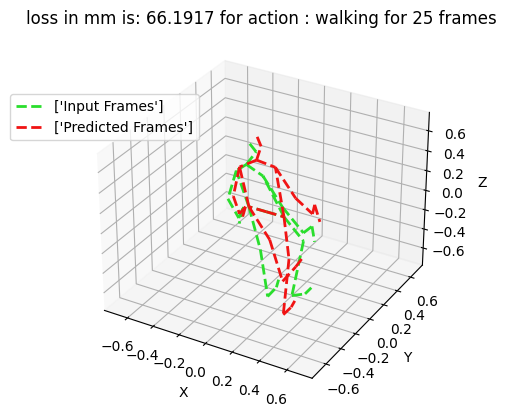

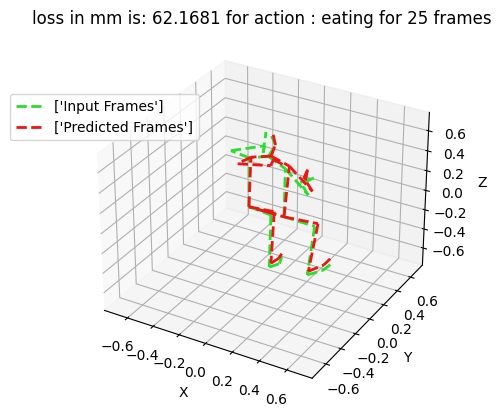

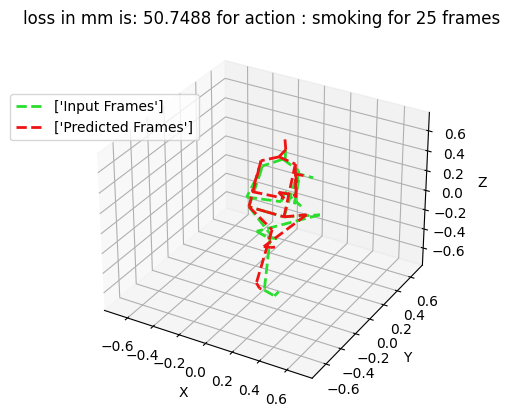

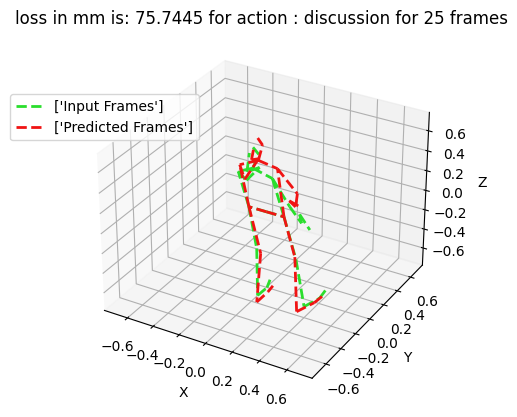

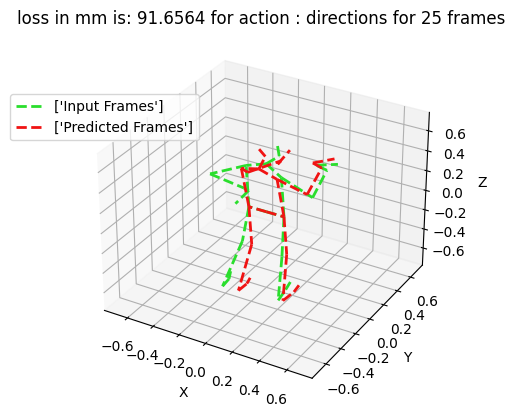

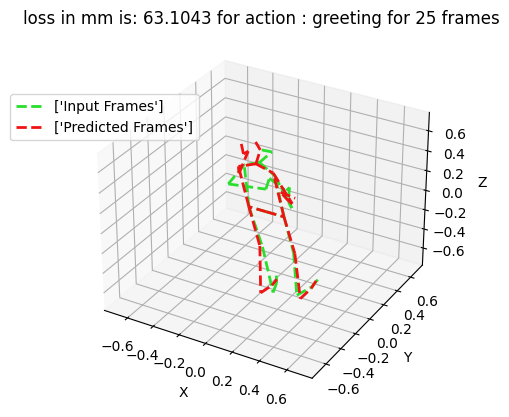

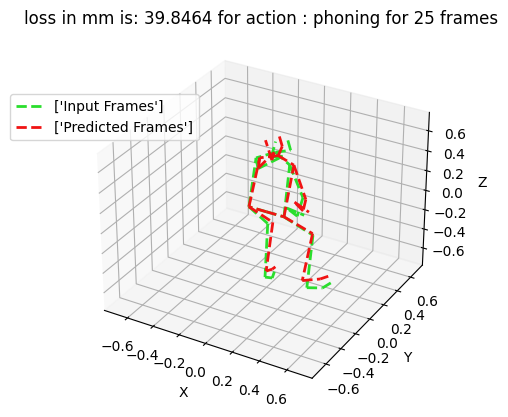

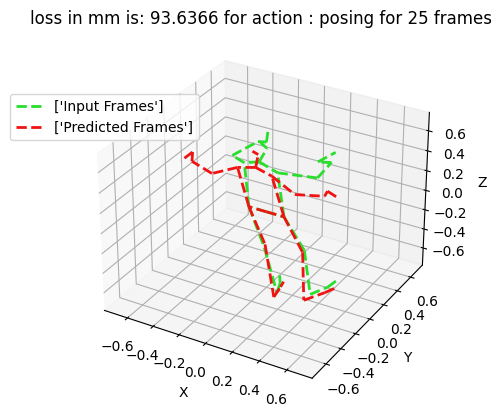

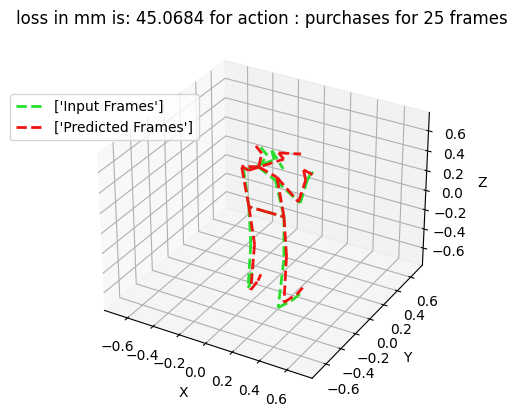

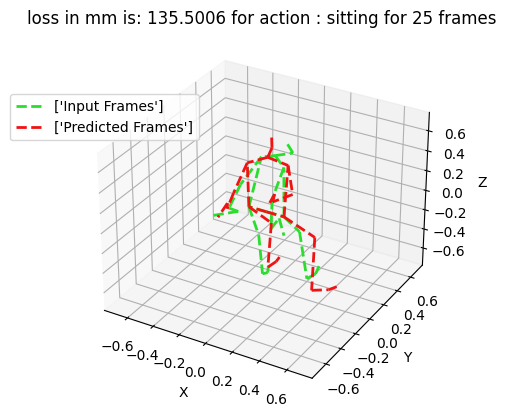

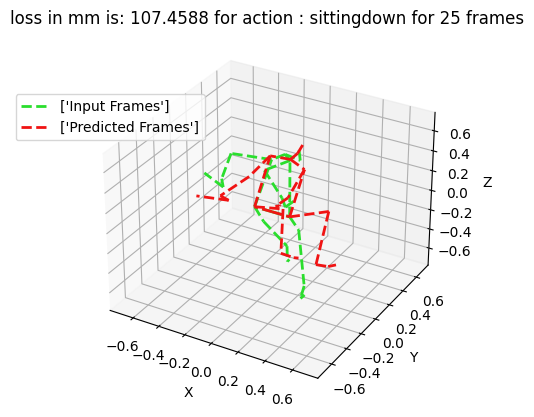

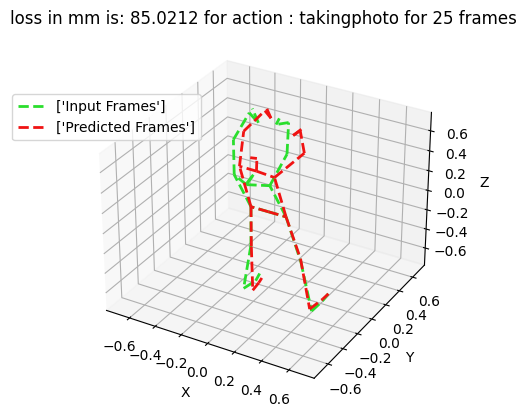

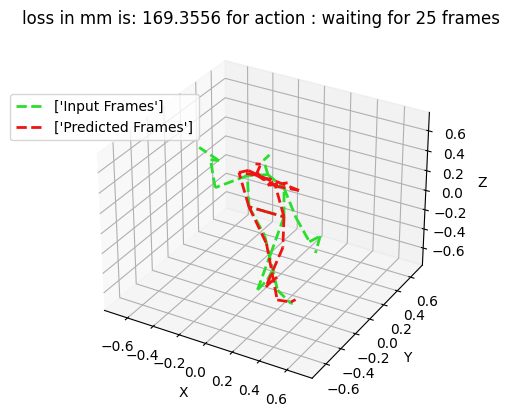

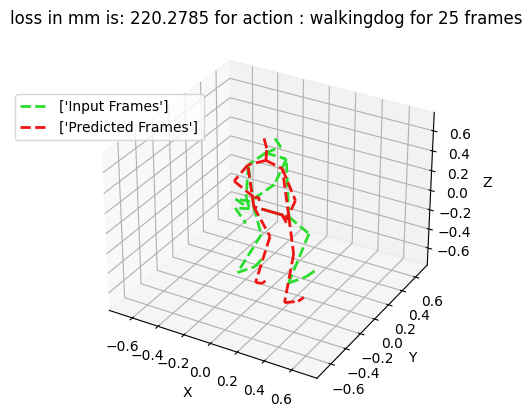

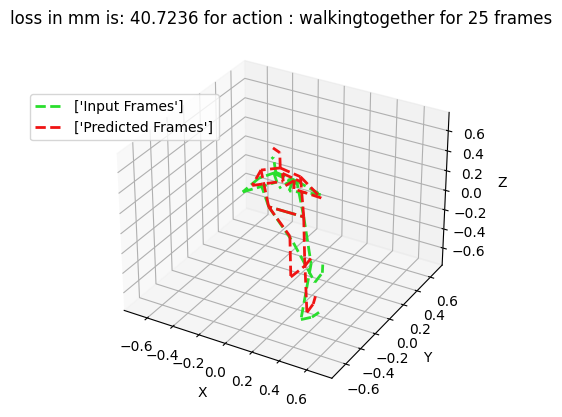

In [ ]:
'''
Insert your code below
'''
visualize_3d_plot(input_n, output_n, visualize_from, path, model, device, n_viz, skip_rate, actions_to_consider_viz)

## Report and Parameter Fine-Tuning Analysis  (**4 Points**)

**Objective:** In this exercise, you will analyze the results obtained from a deep learning model you previously trained and perform parameter fine-tuning to optimize its performance. The key considerations are learning rate, milestones, and weight decay. **You will also use tables and plots to visualize and interpret the outcomes.**

**Instructions:**

1. **Analysis:** Analyze the generated report and answer the following questions:
   - Is there evidence of overfitting or underfitting in the initial training results?
   - Are there fluctuations in training and validation loss or accuracy? If so, what might be causing them?
   - What can you infer from the initial learning rate, milestones, and weight decay settings?

2. **Parameter Fine-Tuning:** Based on your analysis, perform parameter fine-tuning to optimize model performance. Adjust the following parameters:
   - **Learning Rate:** Experiment with different learning rates (higher and lower values) to find an optimal rate.
   - **Milestones:** Modify the milestone values for adjusting the learning rate schedule.
   - **Weight Decay:** Explore different weight decay values.
   

3. **Re-Training:** Train the model with the adjusted hyperparameters. Record the training progress and generate a new report, including performance metrics and line plots as before.

4. **Final Analysis:** Analyze the results of the fine-tuned model and compare them with the initial training. Answer the following questions:
   - Has parameter fine-tuning improved model performance?
   - Did it mitigate overfitting or underfitting issues?
   - What can you conclude about the optimal hyperparameters for this task?


1. **Analysis:** Analyzing the training results, we can state that there is no evidence of overfitting. The training and validation loss curves show consistent behavior, with no significant gap between them. The training and validation losses evolve in a parallel trend, indicating that the model does not capture excessive noise. While overfitting is not a concern in this scenario, we do observe the presence of underfitting. This can be attributed to the model's inability to capture the complexities present in the training data. This phenomenon is supported by the fact that the model's performance on both the training and validation datasets is poor, in fact both training and validation losses stop decreasing very rapidly and remain quite high as the training progresses. We can also observe fluctuations in the loss curves, but they occur primarily within the first 10 epochs of training. These initial fluctuations may be attributed to several factors, including the model's adjustment to the training data and the choice of learning rate. A high learning rate (1e-01) can in fact lead to rapid adjustments in the model's parameters, which may result in significant oscillations in the loss values. As training progresses these fluctuations tend to gradually stabilize. This stabilization becomes more noticeable after each milestone (10 and 30).

2. **Hyperparameter Tuning:** Hyperparameter tuning to optimize model performance:

In [ ]:
model_dir = "./checkpoints/hyperparam_tuning/"
if not exists(model_dir): makedirs(model_dir)

# Arguments to setup the optimizer
lr_range = [1e-01, 1e-02, 1e-03]  # learning rate
use_scheduler = True  # use MultiStepLR scheduler
milestones_range = [[10, 30], [10, 25], [15, 25],
                    [15, 30]]  # the epochs after which the learning rate is adjusted by gamma
gamma = 0.1  #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay_range = [1e-04, 1e-05]  # weight decay (L2 penalty)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

for lr in lr_range:
    for milestones in milestones_range:
        for weight_decay in weight_decay_range:

            model = Model(num_joints=joints_to_consider,
                          num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                          num_channels=3, kernel_size=[3, 3], use_pes=True).to(device)

            print('total number of parameters of the network is: ' + str(
                sum(p.numel() for p in model.parameters() if p.requires_grad)))

            use_scheduler = True  # use MultiStepLR scheduler
            gamma = 0.1  #gamma correction to the learning rate, after reaching the milestone epochs
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

            if use_scheduler:
                scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

            model_path = model_dir + str(lr) + "_" + str(milestones) + "_" + str(weight_decay) + "/"
            makedirs(model_path)
            save_and_plot = True

            val_loss, val_loss_best, epoch_ckpt = train(data_loader, vald_loader, path_to_save_model=model_path)

            # Check the epoch with the best validation loss
            best_val_loss = round(val_loss_best.item(), 4)
            # best_loss_epoch = val_loss.index(val_loss_best.item()) + 1

            print("best_val_loss: ", best_val_loss)
            # print("best_loss_epoch: ", best_loss_epoch)

            print("epoch_ckpt: ", epoch_ckpt)

            ckpt_path = model_path + 'h36m_3d_25frames_ckpt_epoch_' + str(epoch_ckpt) + '.pt'
            test(ckpt_path)

3. **Re-Training:** Let's re-train the model with the following adjusted hyperparameters:
- Learning rate = 1e-01
- Milestones = [15, 20]
- Weigth decay = 1e-05

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 559.719
[Epoch: 1, Iteration:   201]  training loss: 134.031
[Epoch: 1, Iteration:   401]  training loss: 117.532
[Epoch: 1, Iteration:   601]  training loss: 113.309
[Epoch: 1, Iteration:     1]  validation loss: 101.150
[Epoch: 2, Iteration:     1]  training loss: 101.088
[Epoch: 2, Iteration:   201]  training loss: 107.591
[Epoch: 2, Iteration:   401]  training loss: 107.037
[Epoch: 2, Iteration:   601]  training loss: 101.046
[Epoch: 2, Iteration:     1]  validation loss: 96.945
[Epoch: 3, Iteration:     1]  training loss: 101.718
[Epoch: 3, Iteration:   201]  training loss: 98.029
[Epoch: 3, Iteration:   401]  training loss: 96.423
[Epoch: 3, Iteration:   601]  training loss: 95.294
[Epoch: 3, Iteration:     1]  validation loss: 88.974
[Epoch: 4, Iteration:     1]  training loss: 92.824
[Epoch: 4, Iteration:   201]  training loss: 100.047
[Epoch: 4, Iteration:   401]  training loss: 91

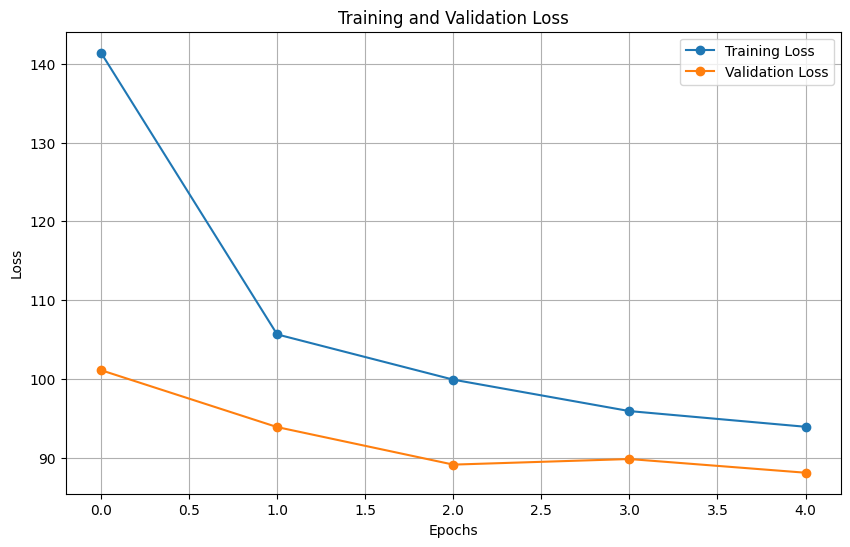

[Epoch: 6, Iteration:     1]  training loss: 91.010
[Epoch: 6, Iteration:   201]  training loss: 92.940
[Epoch: 6, Iteration:   401]  training loss: 89.592
[Epoch: 6, Iteration:   601]  training loss: 88.017
[Epoch: 6, Iteration:     1]  validation loss: 93.701
[Epoch: 7, Iteration:     1]  training loss: 92.343
[Epoch: 7, Iteration:   201]  training loss: 91.042
[Epoch: 7, Iteration:   401]  training loss: 89.509
[Epoch: 7, Iteration:   601]  training loss: 90.181
[Epoch: 7, Iteration:     1]  validation loss: 87.929
[Epoch: 8, Iteration:     1]  training loss: 90.170
[Epoch: 8, Iteration:   201]  training loss: 93.700
[Epoch: 8, Iteration:   401]  training loss: 93.819
[Epoch: 8, Iteration:   601]  training loss: 90.074
[Epoch: 8, Iteration:     1]  validation loss: 84.600
[Epoch: 9, Iteration:     1]  training loss: 91.281
[Epoch: 9, Iteration:   201]  training loss: 81.667
[Epoch: 9, Iteration:   401]  training loss: 92.018
[Epoch: 9, Iteration:   601]  training loss: 83.298
[Epoch

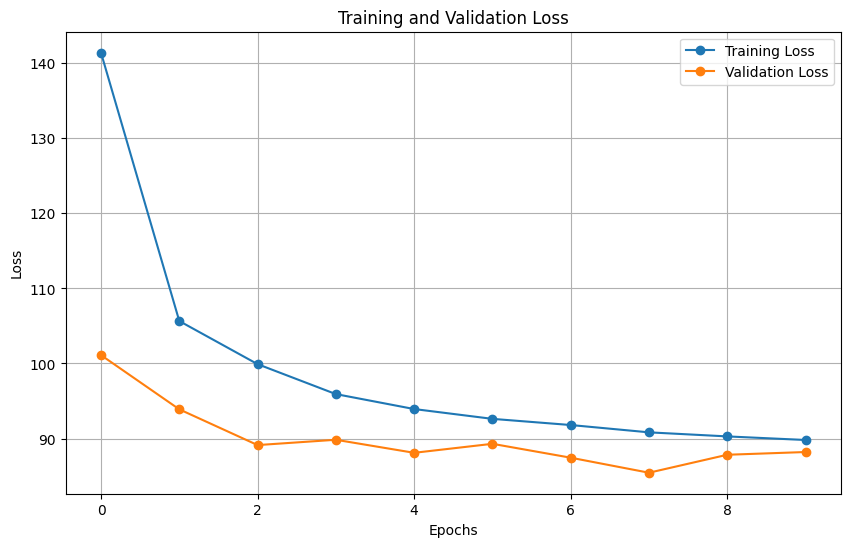

[Epoch: 11, Iteration:     1]  training loss: 88.525
[Epoch: 11, Iteration:   201]  training loss: 89.103
[Epoch: 11, Iteration:   401]  training loss: 91.377
[Epoch: 11, Iteration:   601]  training loss: 90.039
[Epoch: 11, Iteration:     1]  validation loss: 86.248
[Epoch: 12, Iteration:     1]  training loss: 91.318
[Epoch: 12, Iteration:   201]  training loss: 89.999
[Epoch: 12, Iteration:   401]  training loss: 86.066
[Epoch: 12, Iteration:   601]  training loss: 95.318
[Epoch: 12, Iteration:     1]  validation loss: 93.582
[Epoch: 13, Iteration:     1]  training loss: 95.571
[Epoch: 13, Iteration:   201]  training loss: 88.409
[Epoch: 13, Iteration:   401]  training loss: 90.727
[Epoch: 13, Iteration:   601]  training loss: 85.761
[Epoch: 13, Iteration:     1]  validation loss: 79.441
[Epoch: 14, Iteration:     1]  training loss: 91.545
[Epoch: 14, Iteration:   201]  training loss: 92.080
[Epoch: 14, Iteration:   401]  training loss: 84.197
[Epoch: 14, Iteration:   601]  training 

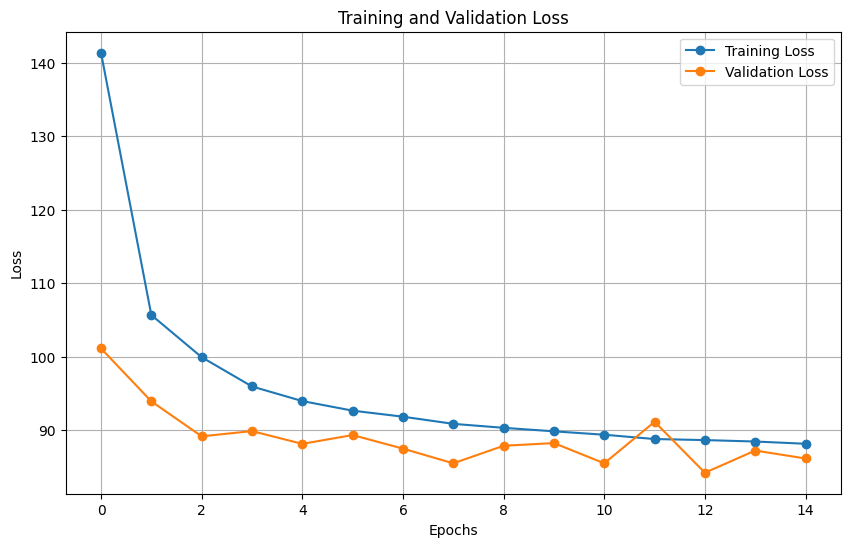

[Epoch: 16, Iteration:     1]  training loss: 88.664
[Epoch: 16, Iteration:   201]  training loss: 83.292
[Epoch: 16, Iteration:   401]  training loss: 88.023
[Epoch: 16, Iteration:   601]  training loss: 86.069
[Epoch: 16, Iteration:     1]  validation loss: 80.451
[Epoch: 17, Iteration:     1]  training loss: 81.696
[Epoch: 17, Iteration:   201]  training loss: 85.941
[Epoch: 17, Iteration:   401]  training loss: 89.632
[Epoch: 17, Iteration:   601]  training loss: 87.810
[Epoch: 17, Iteration:     1]  validation loss: 80.657
[Epoch: 18, Iteration:     1]  training loss: 85.987
[Epoch: 18, Iteration:   201]  training loss: 83.884
[Epoch: 18, Iteration:   401]  training loss: 85.516
[Epoch: 18, Iteration:   601]  training loss: 83.935
[Epoch: 18, Iteration:     1]  validation loss: 80.594
[Epoch: 19, Iteration:     1]  training loss: 85.768
[Epoch: 19, Iteration:   201]  training loss: 81.283
[Epoch: 19, Iteration:   401]  training loss: 90.501
[Epoch: 19, Iteration:   601]  training 

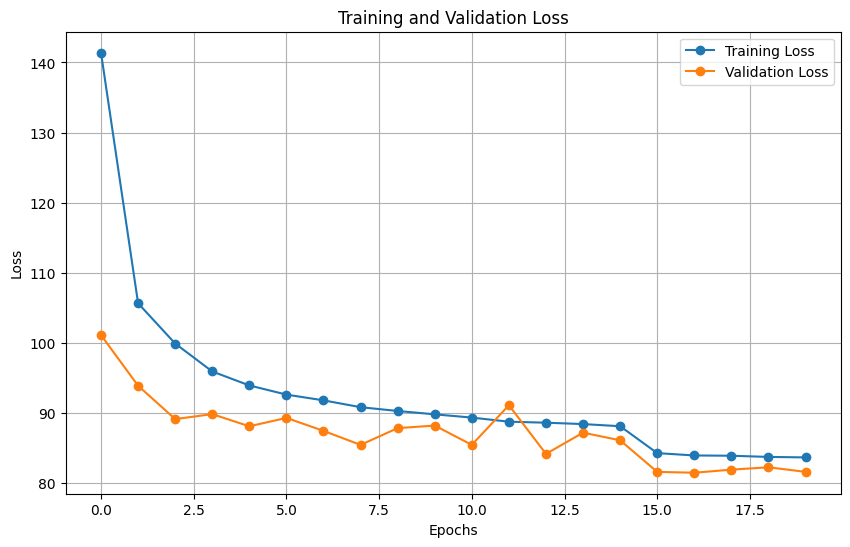

[Epoch: 21, Iteration:     1]  training loss: 79.891
[Epoch: 21, Iteration:   201]  training loss: 79.762
[Epoch: 21, Iteration:   401]  training loss: 84.603
[Epoch: 21, Iteration:   601]  training loss: 81.766
[Epoch: 21, Iteration:     1]  validation loss: 83.954
[Epoch: 22, Iteration:     1]  training loss: 86.104
[Epoch: 22, Iteration:   201]  training loss: 83.804
[Epoch: 22, Iteration:   401]  training loss: 83.949
[Epoch: 22, Iteration:   601]  training loss: 80.635
[Epoch: 22, Iteration:     1]  validation loss: 79.953
[Epoch: 23, Iteration:     1]  training loss: 88.846
[Epoch: 23, Iteration:   201]  training loss: 79.746
[Epoch: 23, Iteration:   401]  training loss: 88.985
[Epoch: 23, Iteration:   601]  training loss: 85.656
[Epoch: 23, Iteration:     1]  validation loss: 84.435
[Epoch: 24, Iteration:     1]  training loss: 86.286
[Epoch: 24, Iteration:   201]  training loss: 86.513
[Epoch: 24, Iteration:   401]  training loss: 84.231
[Epoch: 24, Iteration:   601]  training 

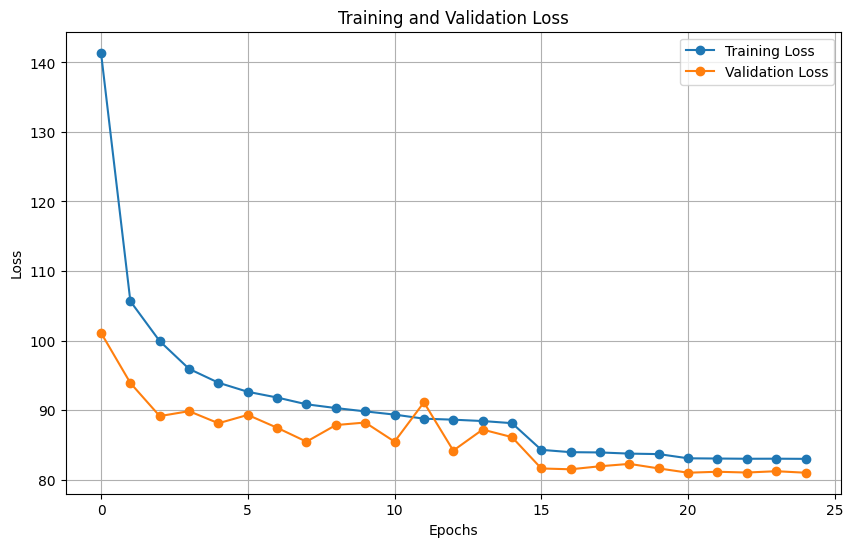

[Epoch: 26, Iteration:     1]  training loss: 82.180
[Epoch: 26, Iteration:   201]  training loss: 83.038
[Epoch: 26, Iteration:   401]  training loss: 83.473
[Epoch: 26, Iteration:   601]  training loss: 82.672
[Epoch: 26, Iteration:     1]  validation loss: 79.270
[Epoch: 27, Iteration:     1]  training loss: 82.728
[Epoch: 27, Iteration:   201]  training loss: 82.109
[Epoch: 27, Iteration:   401]  training loss: 80.282
[Epoch: 27, Iteration:   601]  training loss: 85.240
[Epoch: 27, Iteration:     1]  validation loss: 80.298
[Epoch: 28, Iteration:     1]  training loss: 83.263
[Epoch: 28, Iteration:   201]  training loss: 82.965
[Epoch: 28, Iteration:   401]  training loss: 84.301
[Epoch: 28, Iteration:   601]  training loss: 85.877
[Epoch: 28, Iteration:     1]  validation loss: 82.335
[Epoch: 29, Iteration:     1]  training loss: 87.769
[Epoch: 29, Iteration:   201]  training loss: 84.822
[Epoch: 29, Iteration:   401]  training loss: 81.049
[Epoch: 29, Iteration:   601]  training 

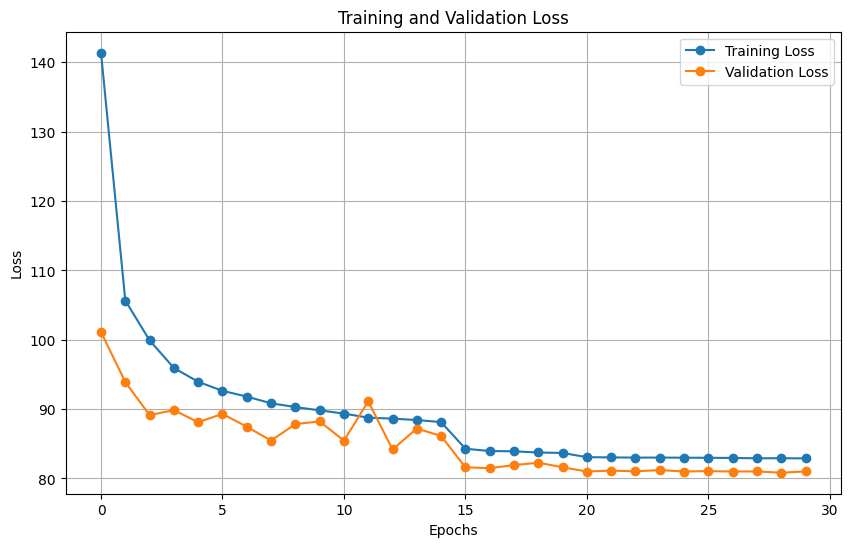

[Epoch: 31, Iteration:     1]  training loss: 82.384
[Epoch: 31, Iteration:   201]  training loss: 82.962
[Epoch: 31, Iteration:   401]  training loss: 79.227
[Epoch: 31, Iteration:   601]  training loss: 80.640
[Epoch: 31, Iteration:     1]  validation loss: 81.186
[Epoch: 32, Iteration:     1]  training loss: 87.214
[Epoch: 32, Iteration:   201]  training loss: 83.080
[Epoch: 32, Iteration:   401]  training loss: 79.813
[Epoch: 32, Iteration:   601]  training loss: 83.062
[Epoch: 32, Iteration:     1]  validation loss: 79.560
[Epoch: 33, Iteration:     1]  training loss: 86.790
[Epoch: 33, Iteration:   201]  training loss: 77.203
[Epoch: 33, Iteration:   401]  training loss: 83.372
[Epoch: 33, Iteration:   601]  training loss: 87.410
[Epoch: 33, Iteration:     1]  validation loss: 82.780
[Epoch: 34, Iteration:     1]  training loss: 82.550
[Epoch: 34, Iteration:   201]  training loss: 78.720
[Epoch: 34, Iteration:   401]  training loss: 80.908
[Epoch: 34, Iteration:   601]  training 

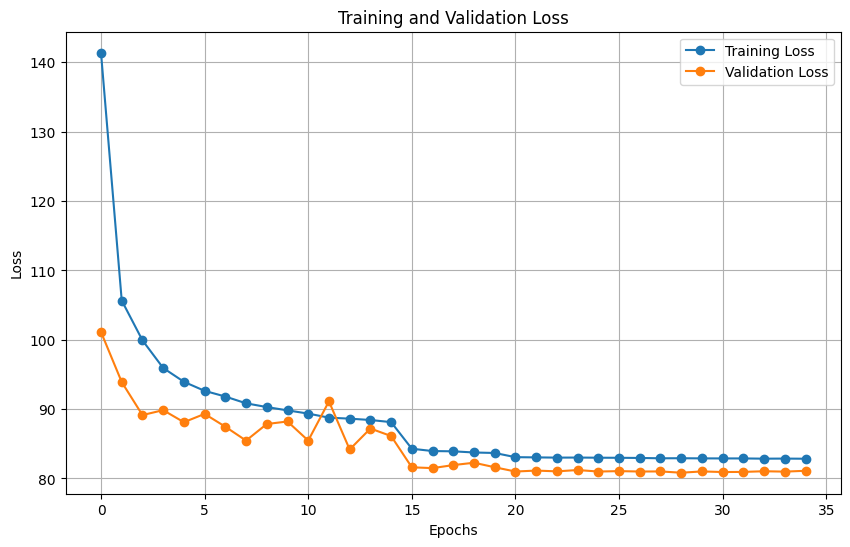

[Epoch: 36, Iteration:     1]  training loss: 81.926
[Epoch: 36, Iteration:   201]  training loss: 84.078
[Epoch: 36, Iteration:   401]  training loss: 81.554
[Epoch: 36, Iteration:   601]  training loss: 82.511
[Epoch: 36, Iteration:     1]  validation loss: 85.374
[Epoch: 37, Iteration:     1]  training loss: 82.149
[Epoch: 37, Iteration:   201]  training loss: 82.535
[Epoch: 37, Iteration:   401]  training loss: 83.867
[Epoch: 37, Iteration:   601]  training loss: 84.251
[Epoch: 37, Iteration:     1]  validation loss: 81.832
[Epoch: 38, Iteration:     1]  training loss: 79.829
[Epoch: 38, Iteration:   201]  training loss: 86.726
[Epoch: 38, Iteration:   401]  training loss: 79.499
[Epoch: 38, Iteration:   601]  training loss: 83.606
[Epoch: 38, Iteration:     1]  validation loss: 76.603
[Epoch: 39, Iteration:     1]  training loss: 86.689
[Epoch: 39, Iteration:   201]  training loss: 80.885
[Epoch: 39, Iteration:   401]  training loss: 78.983
[Epoch: 39, Iteration:   601]  training 

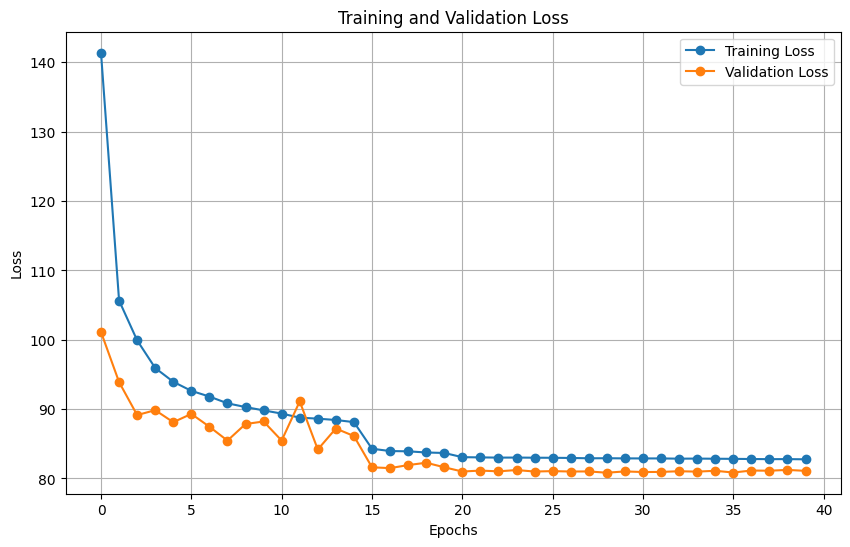

TypeError: ignored

In [ ]:
model_path = "./checkpoints/hyperparam_tuned/"
if not exists(model_path): makedirs(model_path)

# Final hyper-parameters
lr = 1e-01
milestones = [15, 20]
weight_decay = 1e-05

model = Model(num_joints=joints_to_consider,
              num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
              num_channels=3, kernel_size=[3, 3], use_pes=True).to(device)

print('total number of parameters of the network is: ' + str(
    sum(p.numel() for p in model.parameters() if p.requires_grad)))

use_scheduler = True  # use MultiStepLR scheduler
gamma = 0.1  #gamma correction to the learning rate, after reaching the milestone epochs
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

model_path = "./checkpoints/hyperparam_tuned/" + str(lr) + "_" + str(milestones) + "_" + str(weight_decay) + "/"
makedirs(model_path)
save_and_plot = True

train(data_loader, vald_loader, path_to_save_model=model_path)


In [ ]:
ckpt_path = model_path + 'h36m_3d_25frames_ckpt_epoch_' + str(35) + '.pth'
test(ckpt_path)

model loaded


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


walking :  62.6
eating :  58.8
smoking :  62.4
discussion :  88.2
directions :  79.9
greeting :  102.9
phoning :  76.6
posing :  117.9
purchases :  101.4
sitting :  90.2
sittingdown :  113.5
takingphoto :  87.6
waiting :  82.5
walkingdog :  111.1
walkingtogether :  60.3
Average: 86.4
Prediction time:  0.01004911611477534


4. **Final analysis:** Analyzing the obtained results and comparing them with the initial training, we can conclude that hyperparameter fine-tuning has improved the model's performance, even if the improvement was only marginal (from about 87mm to about 83mm ofn the test dataset). However, the underfitting problems persisted and the model's performance is still suboptimal.

## Calculating MPJPE for a Specific Frame  (**2 Points**)


In this exercise, you will calculate the Mean Per Joint Position Error (MPJPE) for a specific frame. This skill is valuable for assessing the accuracy of your model's predictions at a particular moment.

\begin{align*}
\text{MPJPE}_t = \frac{1}{N} \sum_{j=1}^{J} \left\| P_{\text{predicted}_{t,j}} - P_{\text{gt}_{t,j}} \right\|
\end{align*}

Fixed the frame $t$, you will calculate the MPJPE for the predicted pose and the ground truth. Steps:

- Write a function that takes in input the predicted pose and the ground truth one and returns the MPJPE for a number of frames $t$. (e.g. the output could be a dictionary with the frame number as key and the MPJPE as value)
- Rewrite the test function to use the function you just wrote.
- Run the newly created test function for $t=[5, 10, 15, 25]$ and report the results in a table and plot.





In [ ]:
def mpjpe_per_frame(sequences_predict,sequences_gt, frames_to_consider):
    '''
    Insert your code below
    '''

    '''
    Calculate MPJPE for the specified frames.

    Args:
        sequences_predict (torch.Tensor): Predicted pose sequences (batch_size, output_n, num_joints, 3).
        sequences_gt (torch.Tensor): Ground truth pose sequences (batch_size, output_n, num_joints, 3).
        frames_to_consider (list): List of frame numbers to consider.

    Returns:
        dict: A dictionary with frame numbers as keys and MPJPE as values.
    '''

    mpjpe_dict = []  # Dictionary to store the MPJPE for each frame

    for frame in frames_to_consider:
        if frame < sequences_predict.size(1):
            # Get the predicted pose for the specified frame
            predicted_frame = sequences_predict[:, frame, :, :]  # (batch_size, num_joints, 3)

            # Get the ground truth pose for the specified frame
            gt_frame = sequences_gt[:, frame, :, :]  # (batch_size, num_joints, 3)

            # Calculate the L2 (Euclidean) distance between predicted and ground truth poses for each joint
            joint_errors = torch.norm(predicted_frame - gt_frame, dim=2)  # (batch_size, num_joints)

            # Calculate the MPJPE for the specified frame and store it in the dictionary
            mpjpe = torch.mean(joint_errors, dim=1)  # (batch_size,)
            mpjpe_dict.append(mpjpe.mean().item())

    return mpjpe_dict

In [ ]:
def test_per_frame(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0

    loss_action = {}

    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))
      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)

      average_loss_action = []

      for cnt,batch in enumerate(test_loader):

        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          #sequences_predict = model(sequences_train)
          totalll += time.time()-running_time
          counter += 1
          sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          '''
          Insert your code below.
          The function mpjpe_per_frame should return the loss for each frame in the sequence. (e.g. a dictionary with keys the frames and values the loss for each frame)
          Keep a tab of the running loss for each frame and the number of frames in the sequence.
          '''
          frames_to_consider = [5, 10, 15, 24]
          dict_loss = mpjpe_per_frame(all_joints_seq.view(-1, output_n,32,3), sequences_gt.view(-1, output_n,32,3), frames_to_consider)

          average_loss_action.append(dict_loss)

      '''
      Insert your code below.
      Average the loss over all the frames in the sequence and print the results.
      '''
      average_loss_action = np.array(average_loss_action)

      # Create a dictionary to store the results
      loss_per_sequence = {
          frame_int: np.mean(average_loss_action[:,frame_int]) for frame_int in range(len(frames_to_consider))
      }

      loss_action[action] = loss_per_sequence

    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

    for action in actions:
      y_values = list(loss_action[action].values())
      plt.plot(frames_to_consider, y_values, label=action, marker='o')

    # Add labels and a legend
    plt.xlabel('Frame')
    plt.ylabel('Loss')
    plt.title('Line Plot of Data')
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()

model loaded


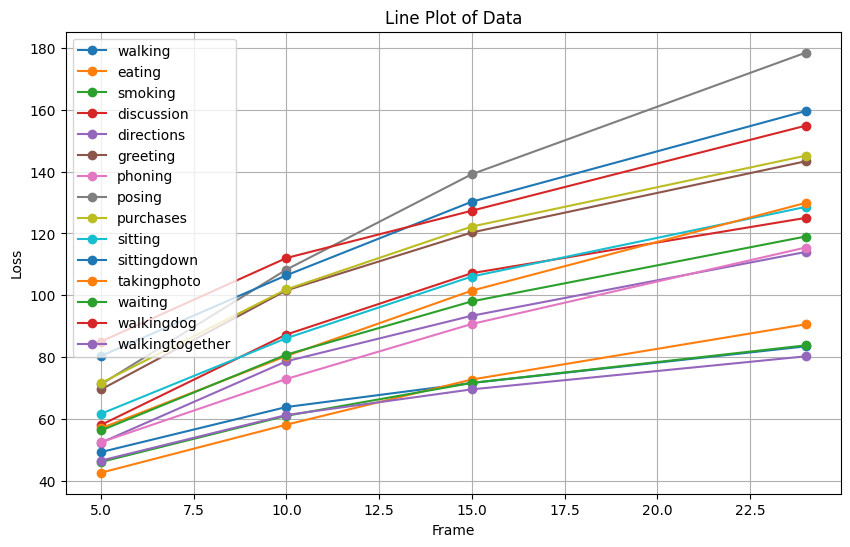

In [ ]:
'''
Insert your code below where you want to load the model and test it.
You need to specify the path to the model checkpoint file and call the test function.
'''
ckpt_path = './checkpoints/h36m_3d_25frames_ckpt_epoch_30.pth'
test_per_frame(ckpt_path)

## Iterative Mechanism (**3 Points**)

In this exercise, you will explore the concept of an iterative mechanism and its adaptability when the model's output length changes. You will start with a model designed to produce 25 output frames but adapt it to generate only 10. The exercise will involve modifying and re-training the model for the new output length. During test time, the model will generate 10 frames and then use them as input to generate the successive 10 frames, and so on, until the desired number of frames is reached. In this case, you are asked to generate 25 frames.

The steps are as follows:
- Change the model's output length from 25 to 10.
- Re-train the model.
- Rewrite the test function to generate 25 frames using the iterative mechanism.
- Generate a new report and compare the results to the baseline model.

In [ ]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n=10 # number of frames to train on (default=10)
output_n=25 # number of frames to predict on
input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22


#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path= './checkpoints/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2

In [ ]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path, input_n, output_n, skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path, input_n, output_n, skip_rate, split=1)

Loading Train Dataset...
Loading Validation Dataset...


In [ ]:
batch_size = 256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)  #

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

>>> Training dataset length: 182327
>>> Validation dataset length: 28560


In [ ]:
from models.sttr.sttformer import Model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s' % device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
              num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
              num_channels=3, kernel_size=[3, 3], use_pes=True).to(device)

print('total number of parameters of the network is: ' + str(
    sum(p.numel() for p in model.parameters() if p.requires_grad)))

Using device: cuda
total number of parameters of the network is: 26694


In [ ]:
ckpt_path = './checkpoints/h36m_3d_25frames_ckpt_epoch_40.pth' # Change the epoch according to the validation curve
original_loss_per_action = test(ckpt_path)

In [ ]:
# Arguments to setup the datasets for iterative mechanism
datas = 'h36m'  # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n = 10  # number of frames to train on (default=10)

'''
Insert your code below
'''
output_n = 10  # number of frames to predict on

input_dim = 3  # dimensions of the input coordinates(default=3)
skip_rate = 1  # # skip rate of frames
joints_to_consider = 22

#FLAGS FOR THE TRAINING
mode = 'train'  #choose either train or test mode

batch_size_test = 8
model_path_iterative = './checkpoints/iterative/'  # path to the model checkpoint file

actions_to_consider_test = 'all'  # actions to test on.
model_name = datas + '_3d_' + str(output_n) + 'frames_ckpt'  #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz = 'all'  # actions to visualize
visualize_from = 'test'
n_viz = 2

In [ ]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Using device: cuda
total number of parameters of the network is: 26694


In [ ]:
# Arguments to setup the optimizer
lr = 1e-01  # learning rate
use_scheduler = True  # use MultiStepLR scheduler
milestones = [10, 30]  # the epochs after which the learning rate is adjusted by gamma
gamma = 0.1  #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay = 1e-05  # weight decay (L2 penalty)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

clip_grad = None  # select max norm to clip gradients
# Argument for training
n_epochs = 41
log_step = 200

### Train and Validation Loop

In [ ]:
save_and_plot = False # save the model and plot the loss. Change to True if you want to save the model and plot the loss

In [ ]:
# launch training with the new output_n
train(data_loader,vald_loader, path_to_save_model=model_path_iterative)

### Test Loop

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    output_tot=25

    loss_action = torch.tensor([])    #a list to contain the running loss for every action (in order)
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(data_path,input_n,output_tot,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          #loss=0
          all_joints_seq=batch.clone()[:, input_n:input_n+output_tot,:]
          sequences_gt=batch[:, input_n:input_n+output_tot, :]

          '''
          Insert your code below. You will need to iteratively predict the next frames and feed it to back to the model until you reach the desired number of frames.
          '''

          for it in range(3):
            output_it = 5 if it==2 else output_n

            if it == 0:
              sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
            else:
              sequence_train=sequences_predict.view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)

            #print((it+1)*input_n+output_it)

            running_time = time.time()
            sequences_predict=model(sequences_train)[:, :output_it, :].view(-1, output_it, joints_to_consider, 3)
            #sequences_predict = model(sequences_train)
            totalll += time.time()-running_time
            counter += 1

            sequences_predict=sequences_predict.contiguous().view(-1,output_it,len(dim_used))

            all_joints_seq[:,it*input_n:(it*input_n)+output_it,dim_used] = sequences_predict

          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss=mpjpe_error(all_joints_seq.view(-1,output_tot,32,3),sequences_gt.view(-1,output_tot,32,3))

          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      loss_action = torch.cat((loss_action, torch.tensor([running_loss/n])), dim=0)

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: '+str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)

    loss_action = loss_action.numpy(force=True)

    fig, ax = plt.subplots(figsize = (15, 8))
    x = np.arange(len(actions))
    width = 0.25

    rects = ax.bar(x, original_loss_per_action, color='red', width=width, label='Original Model')
    #ax.bar_label(rects, padding=3)

    rects = ax.bar(x+width, loss_action, color='blue', width=width, label='Iterative Model')
    #ax.bar_label(rects, padding=3)

    ax.set_ylabel("Loss")
    ax.set_title("Final loss per action")
    ax.set_xticks(x + width, actions)
    ax.legend(loc='upper left', ncols=2)
    plt.show()


model loaded
walking :  100.4
eating :  68.5
smoking :  68.2
discussion :  91.1
directions :  78.2
greeting :  107.6
phoning :  80.6
posing :  113.7
purchases :  99.3
sitting :  82.9
sittingdown :  105.7
takingphoto :  80.6
waiting :  86.0
walkingdog :  113.5
walkingtogether :  83.6
Average: 90.7
Prediction time:  0.008334554566277397


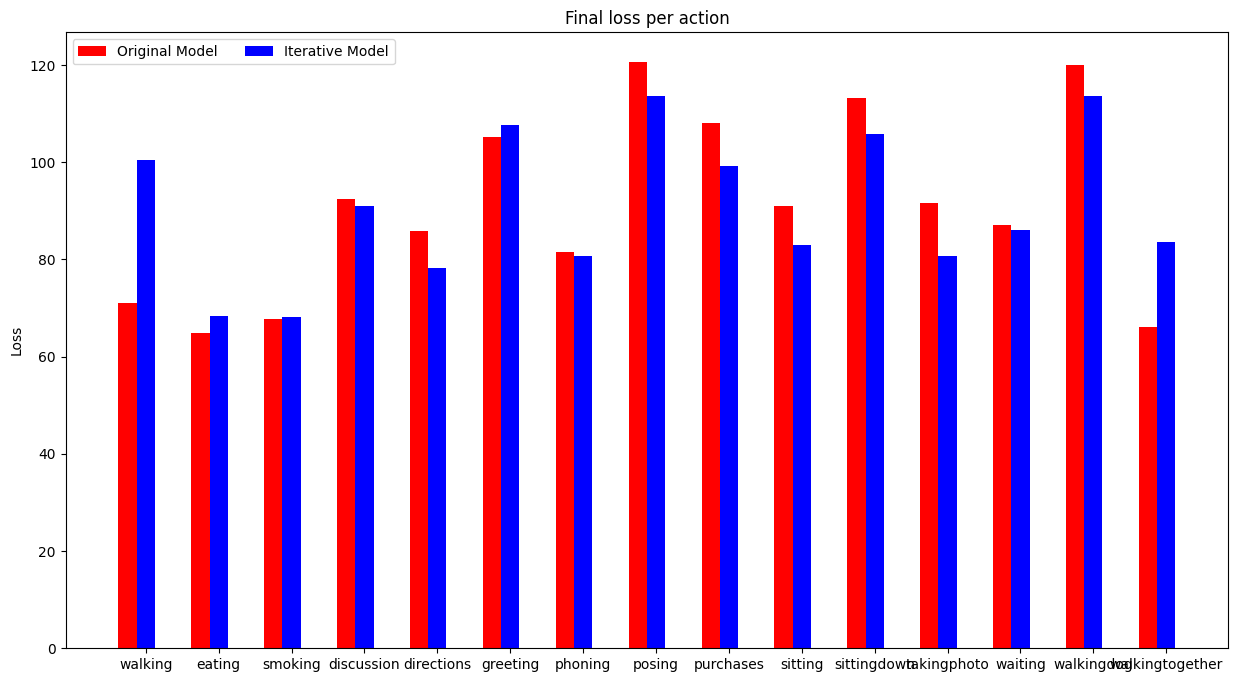

In [ ]:
test(ckpt_path=model_path_iterative+model_name+'_epoch_40.pth')

If we compare these results with the original ones we will se that the two models performe similarly, also with a similar average value.\
Just for two actions, walking and walking together, the iterative model has a significant increment of the loss.

## YOUR custom model (**3 Points**)
 In this exercise, you will implement a Transformer-like network (based on the Theory notebook) for this specific task. You can use the Transformer's Encoder and implement your own Decoder to predict future poses. (e.g. RNN, MLP, CNN, TCN, ...).
 We won't provide any code for this exercise, but you can use the code provided in the Theory notebook as a starting point.
 The goal of this exercise is not to beat the previous model but to understand how to implement a Transformer network for this specific task. For this reason, the evaluation will be based on the code you write and the explanation you provide in the report rather than the results.


### Performance BONUS (**Up to 2 Points**)
- **1 Bonus Point** if the model achieves an A-MPJPE between 80 and 90 millimeters.
- **2 Bonus Points** if the model achieves an A-MPJPE between 70 and 80 millimeters.


In [ ]:
'''
Input Shape: [batch_size, input_time, joints, 3]

Encoder:
Input shape: [batch_size, input_time, joints, 3]
Output shape: [batch_size, input_time/output_time, joints, FREE]

# Decoder:
Input shape: [batch_size, input_time/output_time, joints, FREE]
Output shape: [batch_size, output_time, joints, 3]


Hint: Transformers often take an input of shape [batch_size, time, joints*channels], use the reshape or view function to match the dimensionality.
'''

To deal with the proposed pose prediction task, we implemented a neural network composed of 2 main blocks: the encoder and the decoder.
- **Encoder**: a Transformer-based module that adeptly captures intricate spatial relationships within the input data. Leveraging self-attention mechanisms, it can capture long-range dependencies and efficiently represents the contextual information critical for understanding human pose configurations.
- **Decoder**: a Long Short-Term Memory (LSTM) base module that can exploit the sequential nature of human movements. LSTMs excel in modeling temporal dependencies and capturing the temporal evolution of poses over consecutive frames, allowing the model to discern and predict the dynamic nature of human motion.
By trying to capture both spatial and temporal dependencies, the model can achieve a comprehensive understanding of human pose dynamics.

Let's have a closer examination of the decoder architecture.
The decoder operates in an autoregressive fashion, thanks to the incorporation of LSTM units. This characteristic allows the model to predict one frame at a time, leveraging the information from preceding predictions to inform subsequent ones. The autoregressive LSTM design is pivotal in capturing the temporal evolution of human poses over consecutive frames. To generate a coherent sequence, we employed a loop mechanism that iteratively predicts a single frame in each iteration, updating the hidden states and context based on the preceding predictions. This autoregressive process allows the model to generate a sequence length of 25 frames, ensuring a comprehensive and temporally coherent prediction of human poses.

To enhance the predictive capabilities of the decoder, a key strategy implemented is the integration of **teacher forcing** during the training phase. This technique plays a vital role in training the autoregressive LSTM to generate accurate and coherent pose sequences. During the training phase, instead of relying solely on the model's own predictions as inputs for subsequent time steps, teacher forcing introduces the use of ground truth pose data from the training set. This inclusion of true pose information guides the model during the learning process, helping to mitigate errors that might accumulate in the absence of precise supervision. In this way, the training is more stable and the model can converge more effectively and expediently.\
More in detail, we implemented teacher forcing with a controlled probability *p*, carefully balancing the reliance on the model's own predictions and ground truth data. This probabilistic incorporation introduces an element of variability, preventing the model from becoming overly dependent on the training data while still benefiting from the valuable guidance provided by accurate ground truth information.
Moreover, we have to underline the fact that teacher forcing is exclusively applied during the training process, not during inference, aligning with the model's need to autonomously generate predictions when faced with real-world, unseen data.


In [ ]:
'''
In our pursuit of optimizing model performance, a process of hyperparameter tuning was conducted.
We explored various combinations of key parameters to identify the most effective configuration for enhancing the model's predictive capabilities.
The following are all the value of the parameters that we tested:

lr = [1e-01, 1e-02, 1e-03, 1e-04]
milestones = # setted accordingly to the losses trend
weight_decay = [1e-04, 1e-05]

# Encoder
N = [1, 2, 4] # number of blocks
num_heads = [1, 2, 4, 8] # number of heads
d_model = [128, 256] # hidden dimension of the model
dropout = [0.2, 0.4]

# Decoder
teacher_forcing_ratio = [0.2, 0.3, 0.4, 0.5] # probability of teacher forcing


The best values have been used for the following training:
'''

"\nIn our pursuit of optimizing model performance, a process of hyperparameter tuning was conducted. \nWe explored various combinations of key parameters to identify the most effective configuration for enhancing the model's predictive capabilities. \nThe following are all the value of the parameters that we tested:\n\nlr = [1e-01, 1e-02, 1e-03, 1e-04]\nmilestones = # setted accordingly to the losses trend\nweight_decay = [1e-04, 1e-05]\n\n# Encoder\nN = [1, 2, 4] # number of blocks\nnum_heads = [1, 2, 4, 8] # number of heads\nd_model = [128, 256] # hidden dimension of the model\ndropout = [0.2, 0.4]\n\n# Decoder\nteacher_forcing_ratio = [0.2, 0.3, 0.4, 0.5] # probability of teacher forcing\n\n\nThe best values have been used for the following training:\n"

In [ ]:
import math
import time
from copy import deepcopy

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.autograd
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

from utils import h36motion3d as datasets
from utils.data_utils import define_actions
from utils.loss_funcs import mpjpe_error

import random

from os import makedirs
from os.path import exists

In [ ]:
# Use GPU if available, otherwise stick with cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device, '- Type:', torch.cuda.get_device_name(0))

Using device: cuda - Type: Tesla T4


In [ ]:
# Arguments to setup the datasets
datas = 'h36m'  # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n = 10  # number of frames to train on (default=10)
output_n = 25  # number of frames to predict on
input_dim = 3  # dimensions of the input coordinates(default=3)
skip_rate = 1  # # skip rate of frames
joints_to_consider = 22

#FLAGS FOR THE TRAINING
mode = 'train'  #choose either train or test mode

batch_size_test = 8

actions_to_consider_test = 'all'  # actions to test on.
model_name = datas + '_3d_' + str(output_n) + 'frames_ckpt'  #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz = 'all'  # actions to visualize
visualize_from = 'test'
n_viz = 2

# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path, input_n, output_n, skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path, input_n, output_n, skip_rate, split=1)

batch_size = 256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)  #

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

Loading Train Dataset...


/content/drive/MyDrive/AML_practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


Loading Validation Dataset...
>>> Training dataset length: 180077
>>> Validation dataset length: 28110


In [ ]:
class PositionalEncoding(nn.Module):
    """
    Implement the PE function.
    """

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.num_frames = 10
        self.num_joints = 22

        pos_list = []
        for tk in range(self.num_frames):
            for st in range(self.num_joints):
                pos_list.append(st)

        pos = torch.from_numpy(np.array(pos_list)).unsqueeze(1).float()
        pe = torch.zeros(self.num_frames * self.num_joints, d_model)

        # Compute the positional encodings once in log space.
        '''
        Add your code below
        '''
        denominator = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        # compute pe of all even-indexed positions
        pe[:, 0::2] = torch.sin(pos * denominator)
        # compute pe of all odd-indexed positions
        pe[:, 1::2] = torch.cos(pos * denominator)

        pe = pe.unsqueeze(0)  # the final dimension is (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

In [ ]:
class Attention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, attn_dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, query, key, value, mask=None):
        '''
        add here the code regarding the argument of the softmax function as defined above
        '''

        # Calculate the unnormalized attention scores
        attn = torch.matmul(query, key.transpose(-2, -1))

        # Scale the attention scores by dividing by the square root of the dimension
        attn = attn / math.sqrt(key.size(-1))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        # Apply the softmax function to get the attention weights
        attn = self.dropout(F.softmax(attn, dim=-1))

        '''
        Computed attn, calculate the final output of the attention layer
        '''

        # Calculate the weighted sum using the attention weights
        output = torch.matmul(attn, value)

        return output, attn

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, d_model, dropout=0.1):
        """
        Take in model size and number of heads.
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        #  We assume d_v always equals d_k
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.query_ff = nn.Linear(d_model, d_model)
        self.key_ff = nn.Linear(d_model, d_model)
        self.value_ff = nn.Linear(d_model, d_model)
        self.attn_ff = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.attention = Attention(attn_dropout=dropout)

    def forward(self, query, key, value, mask=None, return_attention=False):

        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k.
        # The query is given as example, you should do the same for key and value
        query = self.query_ff(query).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        '''
        Add your code below
        '''
        key = self.key_ff(key).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value_ff(value).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)

        # 2) Apply attention on all the projected vectors in batch.
        '''
        Add your code below
        '''
        x, self.attn = self.attention(query, key, value, mask=mask)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)

        if return_attention:
            return self.attn_ff(x), self.attn

        return self.attn_ff(x)

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiHeadAttention(num_heads, input_dim)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self_attention part (use self.norm1)
        '''
        Add your code below
        '''
        attn_output = self.self_attn(x, x, x, mask=mask)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)

        # MLP part (use self.norm2)
        '''
        Add your code below
        '''
        mlp_output = self.linear_net(x)
        x = x + self.dropout(mlp_output)
        x = self.norm2(x)

        return x

In [ ]:
class CustomDecoder(nn.Module):
    def __init__(self, input_features=512, output_features=22 * 3, input_frame=10, output_frames=25, num_layers=2, dropout=0.1):
        super(CustomDecoder, self).__init__()
        self.in_features = input_features
        self.out_features = output_features
        self.in_frames = input_frame
        self.out_frames = output_frames
        self.num_layers = num_layers

        self.rnn = nn.LSTM(self.in_features, self.in_features, self.num_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.in_features, 128)
        self.fc2 = nn.Linear(128, self.out_features)

    def forward(self, x, y, teacher_forcing_flag, teacher_forcing_ratio):
        b, s, f = x.shape  # batch_size, input_frame, features

        x, hc = self.rnn(x)  # batch_size, input_frame, features
        full = x[:, -1, :].view(b, 1, -1)

        for i in range(self.out_frames-1):
            if teacher_forcing_flag and random.random() < teacher_forcing_ratio:
                x, hc = self.rnn(x, hc)
            else:
                x, hc = self.rnn(y[:, 1+i:11+i, :], hc)
            # building up the final predicted sequence
            full = torch.cat((full, x[:, -1, :].view(b, 1, -1)), dim=1)

        full = self.fc(full)  # batch_size, output_frames, features_128
        output = self.fc2(F.leaky_relu(full)) # batch_size, output_frames, output_features

        return output

In [ ]:
class Transformer(nn.Module):
    def __init__(self, enc_inp_size, dec_inp_size, N=6, d_model=512, dim_feedforward=2048, num_heads=8, dropout=0.1, teacher_forcing_ratio = 0.5, num_layers_dec=2, mean=[0, 0], std=[0, 0]):
        super(Transformer, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.N = N
        self.mean = mean
        self.std = std
        self.enc_inp_size = enc_inp_size
        self.dec_inp_size = dec_inp_size
        self.tf_ratio = teacher_forcing_ratio
        self.num_layers_dec = num_layers_dec

        self.encoder = nn.ModuleList(
            [deepcopy(EncoderBlock(d_model, num_heads, dim_feedforward, dropout)) for _ in range(N)])
        self.decoder = self.decoder = CustomDecoder(input_features=self.d_model, output_features=22*3, input_frame=10, output_frames=25, num_layers=self.num_layers_dec, dropout=dropout).to(device)

        self.pos_enc = PositionalEncoding(d_model, dropout)

        self.pos_dec = PositionalEncoding(d_model, dropout)
        self.src_embed = nn.Linear(self.enc_inp_size, d_model)
        self.tgt_embed = nn.Linear(self.dec_inp_size, d_model)

        self.init_weights()

    def forward(self, src, trg, src_mask, tf_flag):  #trg, src_mask, trg_mask):

        # First part of the forward pass: embedding and positional encoding
        # both for the source and target

        src = self.pos_enc(self.src_embed(src) * math.sqrt(self.d_model))
        trg = self.pos_dec(self.tgt_embed(trg) * math.sqrt(self.d_model))

        # Second part of the forward pass: the encoder and decoder layers.

        # Encoder
        for encoder_layer in self.encoder:
            src = encoder_layer(src, src_mask)

        # Decoder
        output = self.decoder(src, trg, tf_flag, self.tf_ratio)

        return output

    # Initialize parameters with Glorot / fan_avg.
    def init_weights(self):
        for p in self.encoder.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.decoder.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.pos_enc.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.src_embed.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)

In [ ]:
model = Transformer(enc_inp_size=66, dec_inp_size=66, N=1, d_model=128, dim_feedforward=512, num_heads=2, dropout=0.2, teacher_forcing_ratio=0.2,
                    mean=[0, 0], std=[0, 0]).to(device)

print(model)

print('total number of parameters of the network is: ' + str(
    sum(p.numel() for p in model.parameters() if p.requires_grad)))

Transformer(
  (encoder): ModuleList(
    (0): EncoderBlock(
      (self_attn): MultiHeadAttention(
        (query_ff): Linear(in_features=128, out_features=128, bias=True)
        (key_ff): Linear(in_features=128, out_features=128, bias=True)
        (value_ff): Linear(in_features=128, out_features=128, bias=True)
        (attn_ff): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (attention): Attention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (linear_net): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): ReLU(inplace=True)
        (3): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (decoder): Custom

In [ ]:
# Arguments to setup the optimizer
lr = 1e-03  # learning rate # perf: 1e-03
use_scheduler = True  # use MultiStepLR scheduler
milestones = [20, 30, 35]  # the epochs after which the learning rate is adjusted by gamma
gamma = 0.1  #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay = 1e-05  # weight decay (L2 penalty)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

clip_grad = None  # select max norm to clip gradients
# Argument for training
n_epochs = 41
log_step = 200

In [ ]:
def train(data_loader, vald_loader, path_to_save_model=None):
    train_loss = []
    val_loss = []
    val_loss_best = 1000

    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                         26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                         46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                         75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

    for epoch in range(n_epochs - 1):
        running_loss = 0
        n = 0
        model.train()
        for cnt, batch in enumerate(data_loader):
            batch = batch.float().to(device)
            batch_dim = batch.shape[0]
            n += batch_dim

            sequences_train = batch[:, 0:input_n, dim_used]
            src_mask = torch.ones((sequences_train.shape[0], 1, sequences_train.shape[1])).to(device)
            trg = batch[:, :, dim_used]

            sequences_gt = batch[:, input_n:input_n+output_n, dim_used]

            optimizer.zero_grad()
            sequences_predict = model(sequences_train, trg, src_mask, tf_flag=True).view(-1, output_n, joints_to_consider, 3)

            loss = mpjpe_error(sequences_predict, sequences_gt.view(-1, output_n, len(dim_used) // 3, 3))

            if cnt % log_step == 0:
                print('[Epoch: %d, Iteration: %5d]  training loss: %.3f' % (epoch + 1, cnt + 1, loss.item()))

            loss.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            optimizer.step()
            running_loss += loss * batch_dim

        train_loss.append(running_loss.detach().cpu() / n)
        model.eval()
        with torch.no_grad():
            running_loss = 0
            n = 0
            for cnt, batch in enumerate(vald_loader):
                batch = batch.float().to(device)
                batch_dim = batch.shape[0]
                n += batch_dim

                sequences_train = batch[:, 0:input_n, dim_used]
                src_mask = torch.ones((sequences_train.shape[0], 1, sequences_train.shape[1])).to(device)

                sequences_gt = batch[:, input_n:input_n + output_n, dim_used]
                # trg_mask = subsequent_mask(sequences_gt.shape[1]).repeat(sequences_gt.shape[0], 1, 1).to(device)

                sequences_predict = model(sequences_train, sequences_gt, src_mask, tf_flag=False).view(-1, output_n, joints_to_consider, 3)
                loss = mpjpe_error(sequences_predict, sequences_gt.view(-1, output_n, len(dim_used) // 3, 3))

                if cnt % log_step == 0:
                    print('[Epoch: %d, Iteration: %5d]  validation loss: %.3f' % (epoch + 1, cnt + 1, loss.item()))
                running_loss += loss * batch_dim
            val_loss.append(running_loss.detach().cpu() / n)
            if running_loss / n < val_loss_best:
                val_loss_best = running_loss / n

        if use_scheduler:
            scheduler.step()

        # save and plot model every 5 epochs
        '''
        Insert your code below. Use the argument path_to_save_model to save the model to the path specified.
        '''
        if save_and_plot and (epoch + 1) % 5 == 0:

            if path_to_save_model is not None:
                checkpoint_path = path_to_save_model + f'h36m_3d_25frames_ckpt_epoch_{epoch + 1}.pth'
                torch.save(model.state_dict(), checkpoint_path)

            # Create a plot for training and validation losses
            import matplotlib.pyplot as plt

            plt.figure(figsize=(10, 6))
            plt.plot(range(epoch + 1), train_loss, label='Training Loss', marker='o')
            plt.plot(range(epoch + 1), val_loss, label='Validation Loss', marker='o')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)

            # Save the loss plot to a file if needed
            if path_to_save_model is not None:
                loss_plot_path = path_to_save_model + f'loss_plot_epoch_{epoch + 1}.png'
                plt.savefig(loss_plot_path)

            plt.show()

[Epoch: 1, Iteration:     1]  training loss: 561.995
[Epoch: 1, Iteration:   201]  training loss: 238.919
[Epoch: 1, Iteration:   401]  training loss: 219.661
[Epoch: 1, Iteration:   601]  training loss: 209.435
[Epoch: 1, Iteration:     1]  validation loss: 209.017
[Epoch: 2, Iteration:     1]  training loss: 215.548
[Epoch: 2, Iteration:   201]  training loss: 190.621
[Epoch: 2, Iteration:   401]  training loss: 184.934
[Epoch: 2, Iteration:   601]  training loss: 182.459
[Epoch: 2, Iteration:     1]  validation loss: 167.338
[Epoch: 3, Iteration:     1]  training loss: 178.946
[Epoch: 3, Iteration:   201]  training loss: 181.420
[Epoch: 3, Iteration:   401]  training loss: 187.538
[Epoch: 3, Iteration:   601]  training loss: 169.240
[Epoch: 3, Iteration:     1]  validation loss: 171.314
[Epoch: 4, Iteration:     1]  training loss: 177.461
[Epoch: 4, Iteration:   201]  training loss: 160.727
[Epoch: 4, Iteration:   401]  training loss: 162.270
[Epoch: 4, Iteration:   601]  training l

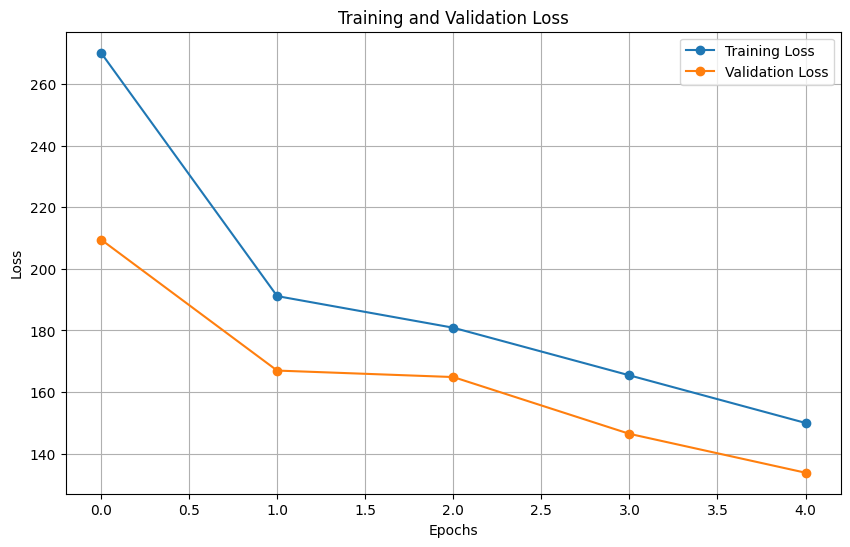

[Epoch: 6, Iteration:     1]  training loss: 142.093
[Epoch: 6, Iteration:   201]  training loss: 144.168
[Epoch: 6, Iteration:   401]  training loss: 136.829
[Epoch: 6, Iteration:   601]  training loss: 136.442
[Epoch: 6, Iteration:     1]  validation loss: 127.903
[Epoch: 7, Iteration:     1]  training loss: 135.637
[Epoch: 7, Iteration:   201]  training loss: 129.858
[Epoch: 7, Iteration:   401]  training loss: 131.800
[Epoch: 7, Iteration:   601]  training loss: 125.922
[Epoch: 7, Iteration:     1]  validation loss: 124.102
[Epoch: 8, Iteration:     1]  training loss: 126.990
[Epoch: 8, Iteration:   201]  training loss: 124.686
[Epoch: 8, Iteration:   401]  training loss: 118.074
[Epoch: 8, Iteration:   601]  training loss: 111.157
[Epoch: 8, Iteration:     1]  validation loss: 116.168
[Epoch: 9, Iteration:     1]  training loss: 114.322
[Epoch: 9, Iteration:   201]  training loss: 109.637
[Epoch: 9, Iteration:   401]  training loss: 111.894
[Epoch: 9, Iteration:   601]  training l

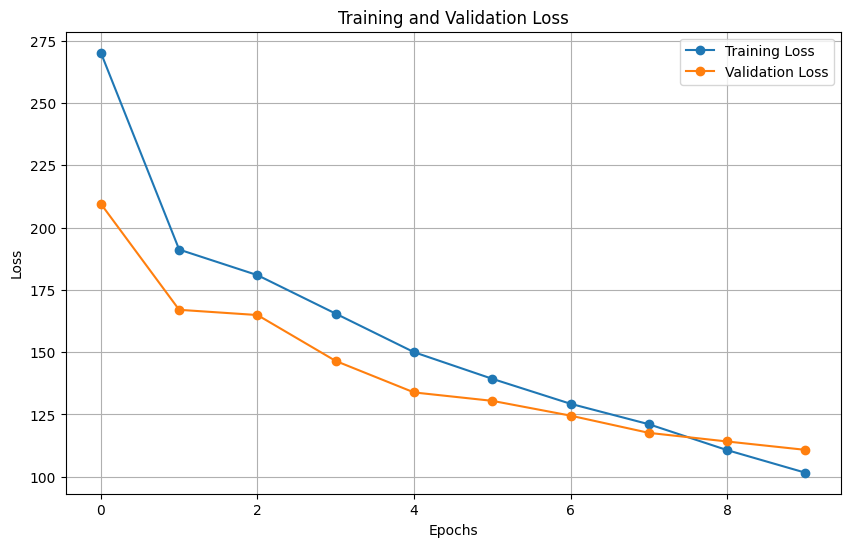

[Epoch: 11, Iteration:     1]  training loss: 95.599
[Epoch: 11, Iteration:   201]  training loss: 96.568
[Epoch: 11, Iteration:   401]  training loss: 94.002
[Epoch: 11, Iteration:   601]  training loss: 92.476
[Epoch: 11, Iteration:     1]  validation loss: 104.454
[Epoch: 12, Iteration:     1]  training loss: 89.704
[Epoch: 12, Iteration:   201]  training loss: 87.901
[Epoch: 12, Iteration:   401]  training loss: 99.718
[Epoch: 12, Iteration:   601]  training loss: 88.820
[Epoch: 12, Iteration:     1]  validation loss: 105.549
[Epoch: 13, Iteration:     1]  training loss: 91.392
[Epoch: 13, Iteration:   201]  training loss: 87.528
[Epoch: 13, Iteration:   401]  training loss: 83.468
[Epoch: 13, Iteration:   601]  training loss: 83.009
[Epoch: 13, Iteration:     1]  validation loss: 103.472
[Epoch: 14, Iteration:     1]  training loss: 87.349
[Epoch: 14, Iteration:   201]  training loss: 80.090
[Epoch: 14, Iteration:   401]  training loss: 86.709
[Epoch: 14, Iteration:   601]  traini

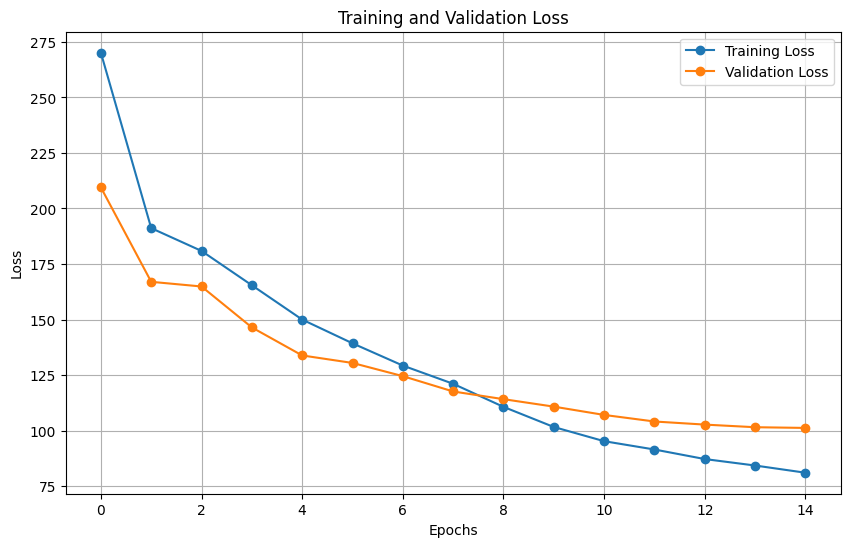

[Epoch: 16, Iteration:     1]  training loss: 79.840
[Epoch: 16, Iteration:   201]  training loss: 80.011
[Epoch: 16, Iteration:   401]  training loss: 79.436
[Epoch: 16, Iteration:   601]  training loss: 76.739
[Epoch: 16, Iteration:     1]  validation loss: 98.299
[Epoch: 17, Iteration:     1]  training loss: 79.060
[Epoch: 17, Iteration:   201]  training loss: 75.261
[Epoch: 17, Iteration:   401]  training loss: 78.921
[Epoch: 17, Iteration:   601]  training loss: 74.317
[Epoch: 17, Iteration:     1]  validation loss: 98.245
[Epoch: 18, Iteration:     1]  training loss: 75.671
[Epoch: 18, Iteration:   201]  training loss: 74.350
[Epoch: 18, Iteration:   401]  training loss: 73.835
[Epoch: 18, Iteration:   601]  training loss: 78.775
[Epoch: 18, Iteration:     1]  validation loss: 95.433
[Epoch: 19, Iteration:     1]  training loss: 73.789
[Epoch: 19, Iteration:   201]  training loss: 75.790
[Epoch: 19, Iteration:   401]  training loss: 74.853
[Epoch: 19, Iteration:   601]  training 

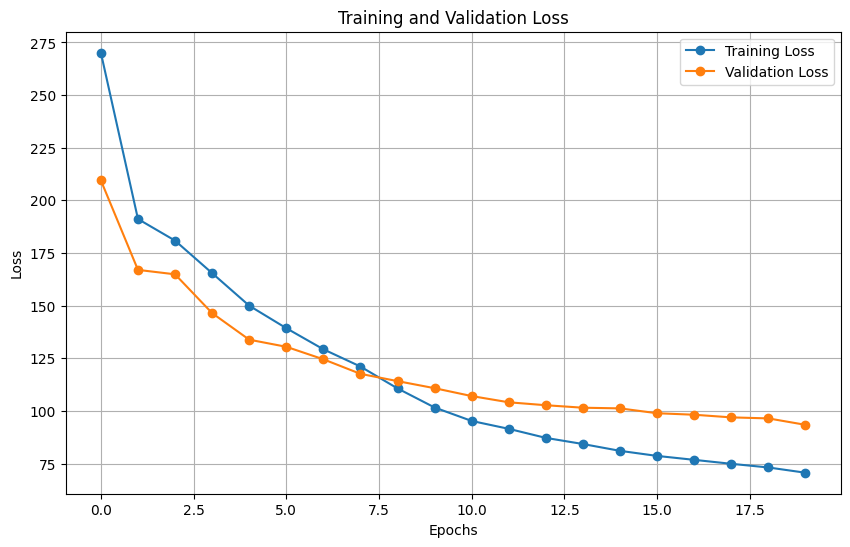

[Epoch: 21, Iteration:     1]  training loss: 66.443
[Epoch: 21, Iteration:   201]  training loss: 66.501
[Epoch: 21, Iteration:   401]  training loss: 71.920
[Epoch: 21, Iteration:   601]  training loss: 70.293
[Epoch: 21, Iteration:     1]  validation loss: 94.542
[Epoch: 22, Iteration:     1]  training loss: 68.084
[Epoch: 22, Iteration:   201]  training loss: 65.930
[Epoch: 22, Iteration:   401]  training loss: 67.328
[Epoch: 22, Iteration:   601]  training loss: 64.989
[Epoch: 22, Iteration:     1]  validation loss: 92.559
[Epoch: 23, Iteration:     1]  training loss: 66.696
[Epoch: 23, Iteration:   201]  training loss: 66.487
[Epoch: 23, Iteration:   401]  training loss: 72.010
[Epoch: 23, Iteration:   601]  training loss: 72.295
[Epoch: 23, Iteration:     1]  validation loss: 95.639
[Epoch: 24, Iteration:     1]  training loss: 65.625
[Epoch: 24, Iteration:   201]  training loss: 65.201
[Epoch: 24, Iteration:   401]  training loss: 64.039
[Epoch: 24, Iteration:   601]  training 

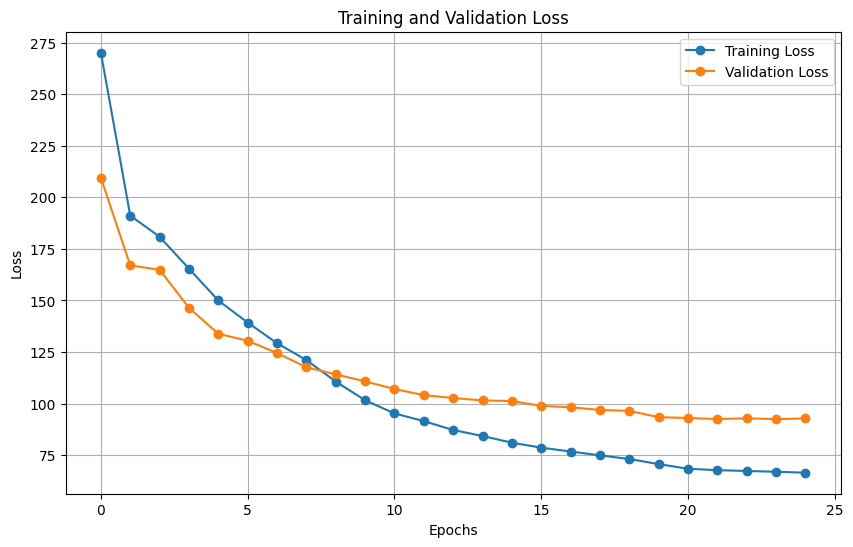

[Epoch: 26, Iteration:     1]  training loss: 65.870
[Epoch: 26, Iteration:   201]  training loss: 65.065
[Epoch: 26, Iteration:   401]  training loss: 65.267
[Epoch: 26, Iteration:   601]  training loss: 64.514
[Epoch: 26, Iteration:     1]  validation loss: 91.515
[Epoch: 27, Iteration:     1]  training loss: 65.054
[Epoch: 27, Iteration:   201]  training loss: 66.948
[Epoch: 27, Iteration:   401]  training loss: 67.744
[Epoch: 27, Iteration:   601]  training loss: 65.386
[Epoch: 27, Iteration:     1]  validation loss: 92.122
[Epoch: 28, Iteration:     1]  training loss: 65.349
[Epoch: 28, Iteration:   201]  training loss: 64.383
[Epoch: 28, Iteration:   401]  training loss: 68.436
[Epoch: 28, Iteration:   601]  training loss: 62.760
[Epoch: 28, Iteration:     1]  validation loss: 89.272
[Epoch: 29, Iteration:     1]  training loss: 63.866
[Epoch: 29, Iteration:   201]  training loss: 66.656
[Epoch: 29, Iteration:   401]  training loss: 70.363
[Epoch: 29, Iteration:   601]  training 

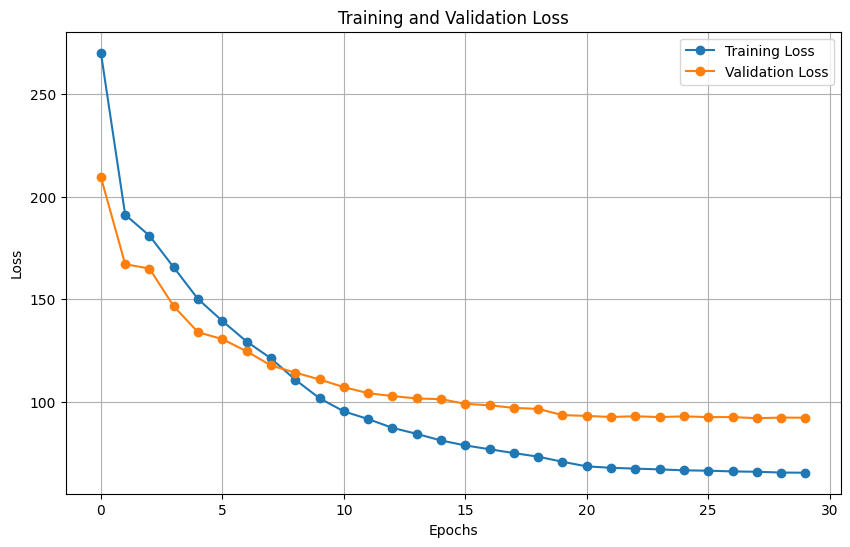

[Epoch: 31, Iteration:     1]  training loss: 65.533
[Epoch: 31, Iteration:   201]  training loss: 63.090
[Epoch: 31, Iteration:   401]  training loss: 64.138
[Epoch: 31, Iteration:   601]  training loss: 62.771
[Epoch: 31, Iteration:     1]  validation loss: 92.670
[Epoch: 32, Iteration:     1]  training loss: 65.789
[Epoch: 32, Iteration:   201]  training loss: 67.784
[Epoch: 32, Iteration:   401]  training loss: 65.282
[Epoch: 32, Iteration:   601]  training loss: 65.841
[Epoch: 32, Iteration:     1]  validation loss: 93.207
[Epoch: 33, Iteration:     1]  training loss: 62.629
[Epoch: 33, Iteration:   201]  training loss: 63.802
[Epoch: 33, Iteration:   401]  training loss: 65.294
[Epoch: 33, Iteration:   601]  training loss: 67.257
[Epoch: 33, Iteration:     1]  validation loss: 92.940
[Epoch: 34, Iteration:     1]  training loss: 63.098
[Epoch: 34, Iteration:   201]  training loss: 64.853
[Epoch: 34, Iteration:   401]  training loss: 65.553
[Epoch: 34, Iteration:   601]  training 

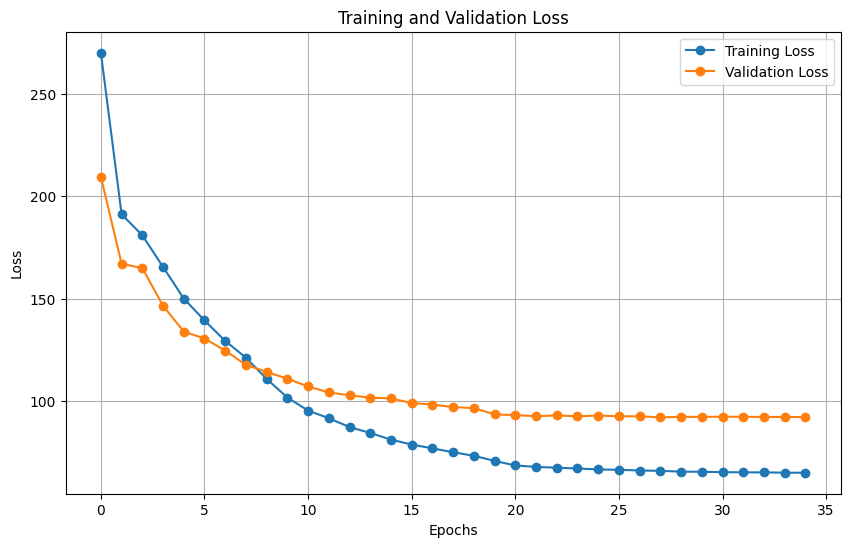

[Epoch: 36, Iteration:     1]  training loss: 64.215
[Epoch: 36, Iteration:   201]  training loss: 64.044
[Epoch: 36, Iteration:   401]  training loss: 65.188
[Epoch: 36, Iteration:   601]  training loss: 62.604
[Epoch: 36, Iteration:     1]  validation loss: 93.134
[Epoch: 37, Iteration:     1]  training loss: 62.405
[Epoch: 37, Iteration:   201]  training loss: 65.287
[Epoch: 37, Iteration:   401]  training loss: 67.354
[Epoch: 37, Iteration:   601]  training loss: 65.292
[Epoch: 37, Iteration:     1]  validation loss: 94.348
[Epoch: 38, Iteration:     1]  training loss: 68.623
[Epoch: 38, Iteration:   201]  training loss: 64.115
[Epoch: 38, Iteration:   401]  training loss: 64.826
[Epoch: 38, Iteration:   601]  training loss: 65.064
[Epoch: 38, Iteration:     1]  validation loss: 92.128
[Epoch: 39, Iteration:     1]  training loss: 64.998
[Epoch: 39, Iteration:   201]  training loss: 62.906
[Epoch: 39, Iteration:   401]  training loss: 66.053
[Epoch: 39, Iteration:   601]  training 

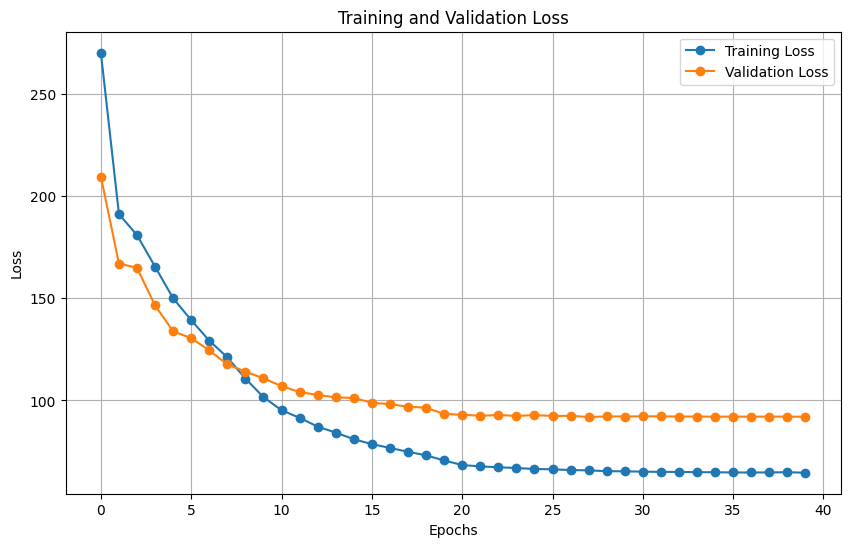

In [ ]:
model_path = "./checkpoints/final_model/"
if not exists(model_path): makedirs(model_path)

save_and_plot = True  # save the model and plot the loss. Change to True if you want to save the model and plot the loss

# launch training
train(data_loader, vald_loader, path_to_save_model=model_path)

By analyzing the training results, it is evident that there is no sign of overfitting. The two loss curves follow a similar trend, overlapping at one point and never deviating significantly from each other. This observation suggests that the model has not excessively memorized the intricacies of the training data and that the introduction of the teacher forcing technique does not allow the model to cheat and copy from the future. Despite the absence of overfitting, there could be a potential underfitting, where the model may not have fully grasped the intricacies of human poses. In fact, after a certain number of epochs, the model stops learning and the two loss curves remain stable.

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss = 0
    n_batches = 0  # number of batches for all the sequences
    actions = define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                         26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                         46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                         75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll = 0
    counter = 0
    for action in actions:
        running_loss = 0
        n = 0
        dataset_test = datasets.Datasets(path, input_n, output_n, skip_rate, split=2, actions=[action])
        # print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

        test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0,
                                 pin_memory=True)
        for cnt, batch in enumerate(test_loader):
            with torch.no_grad():
                batch = batch.to(device)
                batch_dim = batch.shape[0]
                n += batch_dim

                all_joints_seq = batch.clone()[:, input_n:input_n + output_n, :]

                sequences_train = batch[:, 0:input_n, dim_used]
                src_mask = torch.ones((sequences_train.shape[0], 1, sequences_train.shape[1])).to(device)

                trg = batch[:, :, dim_used]

                sequences_gt = batch[:, input_n:input_n+output_n, :]

                running_time = time.time()
                sequences_predict = model(sequences_train, trg, src_mask, tf_flag=False).view(-1, output_n, joints_to_consider, 3)

                #sequences_predict = model(sequences_train)
                totalll += time.time() - running_time
                counter += 1
                sequences_predict = sequences_predict.contiguous().view(-1, output_n, len(dim_used))

                all_joints_seq[:, :, dim_used] = sequences_predict

                all_joints_seq[:, :, index_to_ignore] = all_joints_seq[:, :, index_to_equal]

                loss = mpjpe_error(all_joints_seq.view(-1, output_n, 32, 3), sequences_gt.view(-1, output_n, 32, 3))
                running_loss += loss * batch_dim
                accum_loss += loss * batch_dim

        #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
        print(str(action), ': ', str(np.round((running_loss / n).item(), 1)))
        n_batches += n
    print('Average: ' + str(np.round((accum_loss / n_batches).item(), 1)))
    print('Prediction time: ', totalll / counter)

ckpt_path = './checkpoints/final_model/h36m_3d_25frames_ckpt_epoch_40.pth'  # Change the epoch according to the validation curve
test(ckpt_path)

model loaded
walking :  45.4
eating :  51.9
smoking :  64.1
discussion :  61.0
directions :  60.3
greeting :  63.3
phoning :  71.2
posing :  84.8
purchases :  71.9
sitting :  92.7
sittingdown :  119.7
takingphoto :  86.1
waiting :  70.7
walkingdog :  85.6
walkingtogether :  53.3
Average: 72.1
Prediction time:  0.010029707352320354


['walking', 'eating', 'smoking', 'discussion', 'directions', 'greeting', 'phoning', 'posing', 'purchases', 'sitting', 'sittingdown', 'takingphoto', 'waiting', 'walkingdog', 'walkingtogether']
 ... doing action = walking
 ... doing action = eating
 ... doing action = smoking
 ... doing action = discussion
 ... doing action = directions
 ... doing action = greeting
 ... doing action = phoning
 ... doing action = posing
 ... doing action = purchases
 ... doing action = sitting
 ... doing action = sittingdown
 ... doing action = takingphoto
 ... doing action = waiting
 ... doing action = walkingdog
 ... doing action = walkingtogether


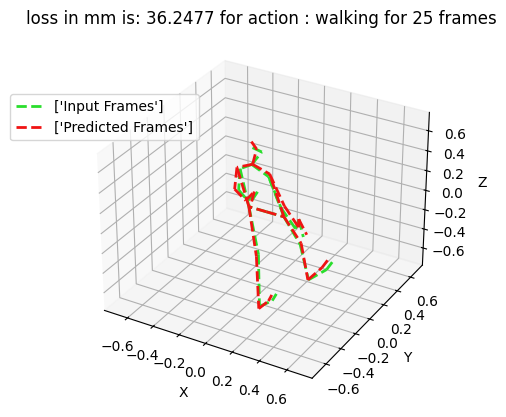

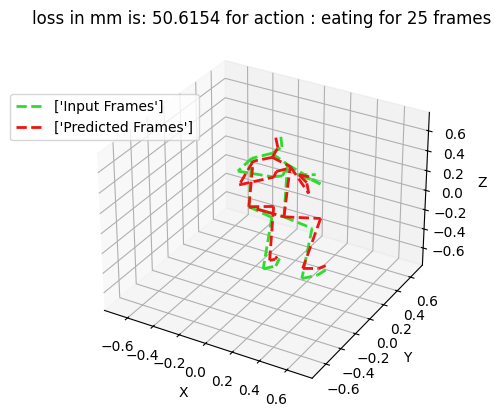

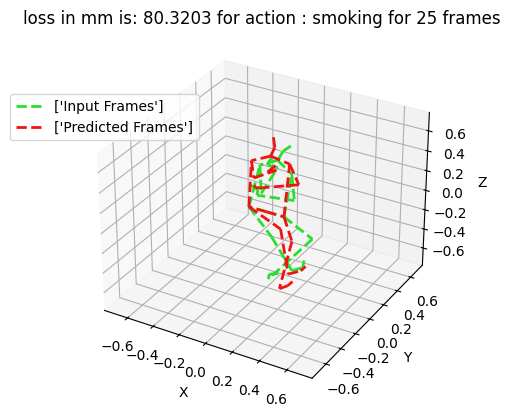

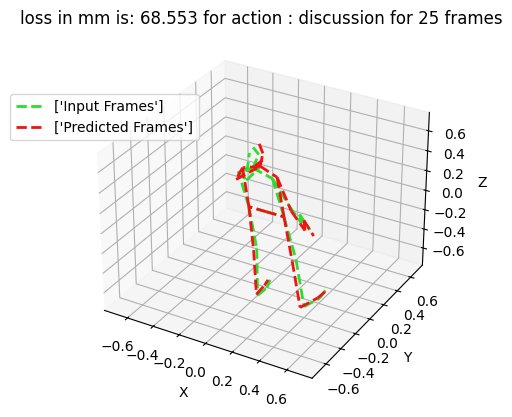

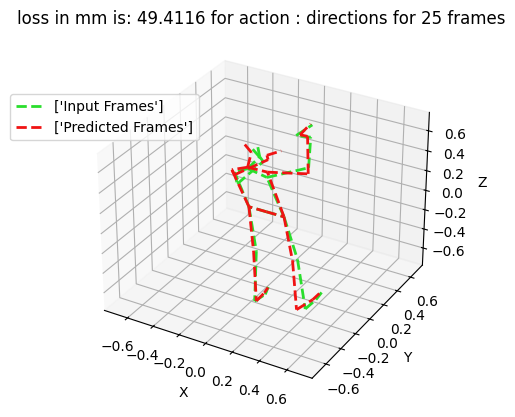

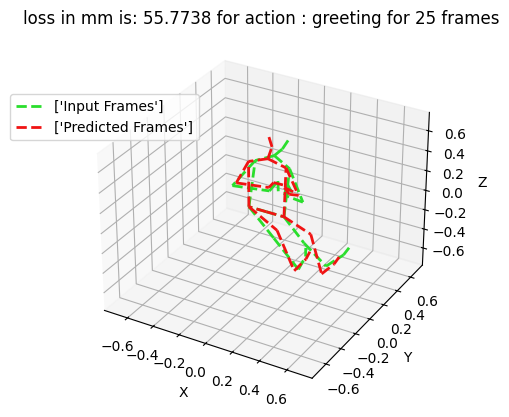

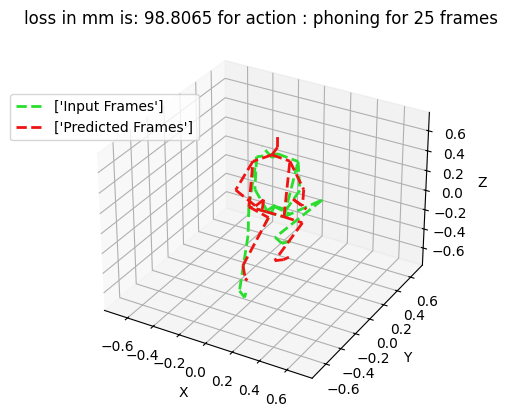

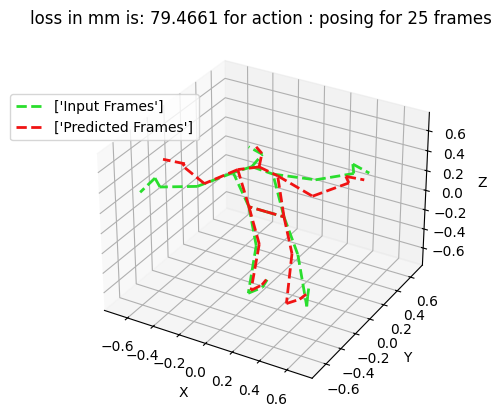

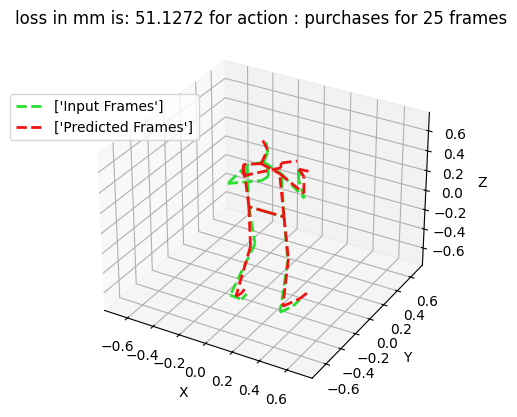

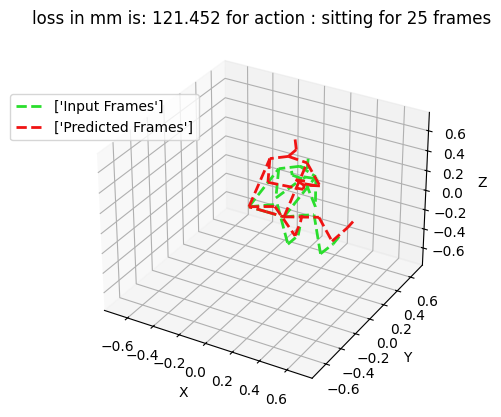

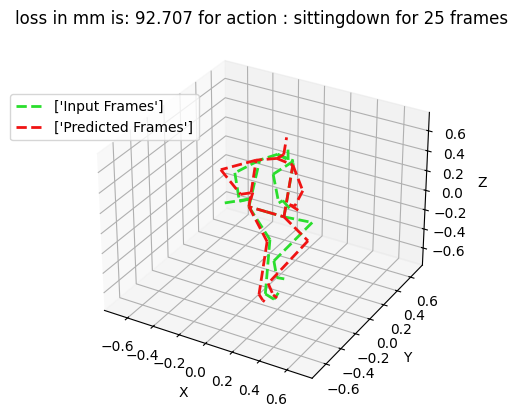

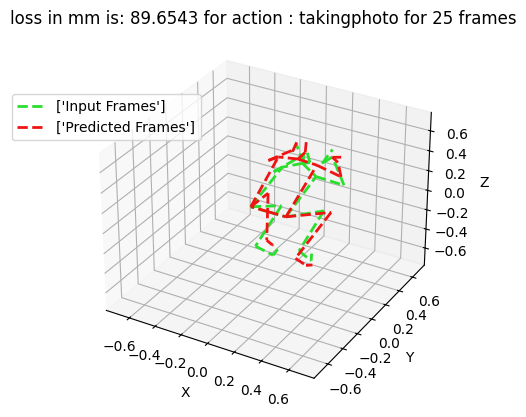

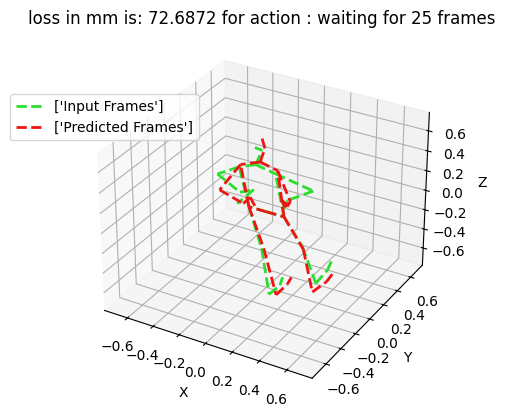

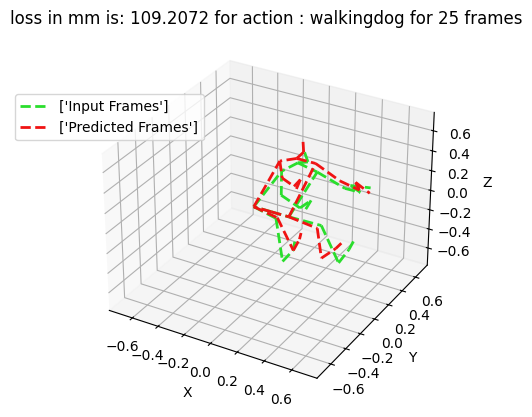

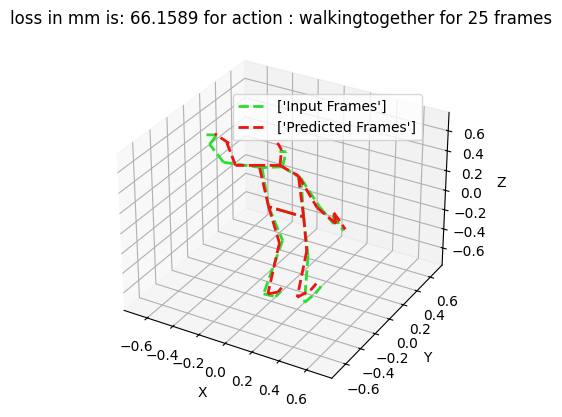

In [ ]:
def create_pose(ax, plots, vals, pred=True, update=False):
    # [16, 20, 23, 24, 28, 31] IGNORE
    # [13, 19, 22, 13, 27, 30] EQUAL
    # h36m 32 joints(full)
    connect = [
        (1, 2), (2, 3), (3, 4), (4, 5),
        (6, 7), (7, 8), (8, 9), (9, 10),
        (0, 1), (0, 6),
        (6, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22),
        (1, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
        (24, 25), (24, 17),
        (24, 14), (14, 15)
    ]

    LR = [
        False, True, True, True,
        True, True, False, False,
        False, False,
        False, True, True, True, True, True, True,
        False, False, False, False, False, False, False, True,
        False, True, True, True, True,
        True, True
    ]

    # Start and endpoints of our representation
    I = np.array([touple[0] for touple in connect])
    J = np.array([touple[1] for touple in connect])

    # Left / right indicator
    LR = np.array([LR[a] or LR[b] for a, b in connect])
    if pred:
        lcolor = "#f01313"
        rcolor = "#f01313"
    else:
        lcolor = "#2ade2d"
        rcolor = "#2ade2d"

    for i in np.arange(len(I)):
        x = np.array([vals[I[i], 0], vals[J[i], 0]])
        z = np.array([vals[I[i], 1], vals[J[i], 1]])
        y = np.array([vals[I[i], 2], vals[J[i], 2]])
        if not update:

            if i == 0:
                plots.append(ax.plot(x, y, z, lw=2, linestyle='--', c=lcolor if LR[i] else rcolor,
                                     label=['Input Frames' if not pred else 'Predicted Frames']))
            else:
                plots.append(ax.plot(x, y, z, lw=2, linestyle='--', c=lcolor if LR[i] else rcolor))

        elif update:
            plots[i][0].set_xdata(x)
            plots[i][0].set_ydata(y)
            plots[i][0].set_3d_properties(z)
            plots[i][0].set_color(lcolor if LR[i] else rcolor)

    return plots


def update(num, data_gt, data_pred, plots_gt, plots_pred, fig, ax):
    gt_vals = data_gt[num]
    pred_vals = data_pred[num]
    plots_gt = create_pose(ax, plots_gt, gt_vals, pred=False, update=True)
    plots_pred = create_pose(ax, plots_pred, pred_vals, pred=True, update=True)

    r = 0.75
    xroot, zroot, yroot = gt_vals[0, 0], gt_vals[0, 1], gt_vals[0, 2]
    ax.set_xlim3d([-r + xroot, r + xroot])
    ax.set_ylim3d([-r + yroot, r + yroot])
    ax.set_zlim3d([-r + zroot, r + zroot])
    #ax.set_title('pose at time frame: '+str(num))
    #ax.set_aspect('equal')

    return plots_gt, plots_pred


def visualize_3d_plot(input_n, output_n, visualize_from, path, modello, device, n_viz, skip_rate, actions):
    actions = define_actions(actions)

    print(actions)

    for action in actions:
        print(f" ... doing action = {action}")

        if visualize_from == 'train':
            loader = datasets.Datasets(path, input_n, output_n, skip_rate, split=0, actions=[action])
        elif visualize_from == 'validation':
            loader = datasets.Datasets(path, input_n, output_n, skip_rate, split=1, actions=[action])
        elif visualize_from == 'test':
            loader = datasets.Datasets(path, input_n, output_n, skip_rate, split=2, actions=[action])

        dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                             26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                             46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                             75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
        # joints at same loc
        joints_to_consider = 22
        joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
        index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
        joint_equal = np.array([13, 19, 22, 13, 27, 30])
        index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))

        loader = DataLoader(loader, batch_size=1, shuffle=True, num_workers=0)

        for cnt, batch in enumerate(loader):

            batch = batch.to(device)

            all_joints_seq = batch.clone()[:, input_n:input_n + output_n, :]

            sequences_train = batch[:, 0:input_n, dim_used]
            src_mask = torch.ones((sequences_train.shape[0], 1, sequences_train.shape[1])).to(device)

            trg = batch[:, :, dim_used]

            sequences_gt = batch[:, input_n:input_n+output_n, :]

            sequences_predict = modello(sequences_train, trg, src_mask, tf_flag=False).view(-1, output_n, joints_to_consider, 3)

            sequences_predict = sequences_predict.contiguous().view(-1, output_n, len(dim_used))
            all_joints_seq[:, :, dim_used] = sequences_predict

            all_joints_seq[:, :, index_to_ignore] = all_joints_seq[:, :, index_to_equal]

            all_joints_seq = all_joints_seq.view(-1, output_n, 32, 3)

            sequences_gt = sequences_gt.view(-1, output_n, 32, 3)

            loss = mpjpe_error(all_joints_seq, sequences_gt)  # # both must have format (batch,T,V,C)

            data_pred = torch.squeeze(all_joints_seq, 0).cpu().data.numpy() / 1000  # in meters
            data_gt = torch.squeeze(sequences_gt, 0).cpu().data.numpy() / 1000

            fig = plt.figure()
            #ax = Axes3D(fig)
            ax = fig.add_subplot(projection='3d')
            vals = np.zeros((32, 3))  # or joints_to_consider
            gt_plots = []
            pred_plots = []

            gt_plots = create_pose(ax, gt_plots, vals, pred=False, update=False)
            pred_plots = create_pose(ax, pred_plots, vals, pred=True, update=False)

            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")
            # ax.set_axis_off()
            ax.legend(bbox_to_anchor=(.35, 0.85))

            ax.set_xlim3d([-1, 1.5])
            ax.set_xlabel('X')

            ax.set_ylim3d([-1, 1.5])
            ax.set_ylabel('Y')

            ax.set_zlim3d([0.0, 1.5])
            ax.set_zlabel('Z')
            ax.set_title(
                'loss in mm is: ' + str(round(loss.item(), 4)) + ' for action : ' + str(action) + ' for ' + str(
                    output_n) + ' frames')

            #plt.rcParams['grid.color'] = "white" # COMMENT FOR GRID

            line_anim = animation.FuncAnimation(fig, update, output_n, fargs=(data_gt, data_pred, gt_plots, pred_plots,
                                                                              fig, ax), interval=70, blit=False)
            #plt.show()

            model_dir = "./checkpoint/final_model/gifs/"
            if not exists(model_dir): makedirs(model_dir)

            line_anim.save(f'./checkpoint/final_model/gifs/human_viz_{action}.gif', writer='pillow')

            if cnt == n_viz - 1:
                plt.close()
                break


visualize_3d_plot(input_n, output_n, visualize_from, path, model, device, n_viz, skip_rate, actions_to_consider_viz)

A possible manifestation of the underfitting phenomenon is visible during the 3d visualization of the comparison between the predicted sequence and the ground truth. The model struggles to predict the final parts of the sequence, especially if they represent large and fast movements. Note, however, that those kind of movements are more accurately predicted if they are in the first half of the generated frames.

In conclusion, our human pose prediction model, while exhibiting a notable underfitting phenomenon in capturing rapid and extensive movements, has demonstrated a commendable proficiency in accurately predicting poses characterized by slower and deliberate transitions, e.g. walking.